In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
from mpl_toolkits.mplot3d import Axes3D
from compartmentalModel import compartmentalModel
from scipy.optimize import minimize, least_squares
from sklearn.model_selection import ParameterGrid
import tqdm

In [2]:
data = pd.read_csv('caso_full.csv')

In [3]:
data.columns

Index(['city', 'city_ibge_code', 'date', 'epidemiological_week',
       'estimated_population', 'estimated_population_2019', 'is_last',
       'is_repeated', 'last_available_confirmed',
       'last_available_confirmed_per_100k_inhabitants', 'last_available_date',
       'last_available_death_rate', 'last_available_deaths', 'order_for_place',
       'place_type', 'state', 'new_confirmed', 'new_deaths'],
      dtype='object')

## Data ingestion

In [4]:
mapping = {}
mapping['AC'] = "Norte"
mapping['AL'] = "Nordeste"
mapping['AM'] = "Norte"
mapping['AP'] = "Norte"
mapping['BA'] = "Nordeste"
mapping['CE'] = "Nordeste"
mapping['DF'] = "Centro Oeste"
mapping['ES'] = "Sudeste"
mapping['GO'] = "Centro Oeste"
mapping['MA'] = "Nordeste"
mapping['MG'] = "Sudeste"
mapping['MS'] = "Centro Oeste"
mapping['MT'] = "Centro Oeste"
mapping['PA'] = "Norte"
mapping['PB'] = "Nordeste"
mapping['PE'] = "Nordeste"
mapping['PI'] = "Nordeste"
mapping['PR'] = "Sul"
mapping['RJ'] = "Sudeste"
mapping['RN'] = "Nordeste"
mapping['RO'] = "Centro Oeste"
mapping['RR'] = "Norte"
mapping['RS'] = "Sul"
mapping['SC'] = "Sul"
mapping['SE'] = "Nordeste"
mapping['SP'] = "Sudeste"
mapping['TO'] = "Norte"

In [5]:
field = "last_available_confirmed"
data = data[(data['city'].isnull() == False) & (data['is_repeated'] == False)]
columns_to_drop = ['city','place_type',
                   'last_available_date','estimated_population',
                   'is_last','is_repeated']
data['date'] = pd.to_datetime(data['date'],format='%Y-%m-%d')
data['region'] = data.apply (lambda row: mapping[row["state"]], axis=1)
pop_estimation = data[["estimated_population","region"]].groupby("region").sum()
data.drop(columns=columns_to_drop,inplace=True)

In [6]:
data["state"].nunique()

27

In [7]:
data.region.unique()

array(['Norte', 'Nordeste', 'Centro Oeste', 'Sudeste', 'Sul'],
      dtype=object)

### Interpolate missing data

In [8]:
min_date = data["date"].min()
max_date = data["date"].max()
delta = max_date - min_date
dates = pd.date_range(start=min_date, end=max_date, freq='D')
def interpolate_mun(mun_data,field):
    #series = mun_data[["last_available_confirmed_per_100k_inhabitants","date","region"]]
    series = mun_data[[field,"date","region"]]
    region_ = series.iloc[0].region
    series = series.set_index("date").reindex(dates).interpolate().ffill().fillna(0)
    series["region"] = region_
    return series

### Aggregate week data at each region

In [9]:
agg_data = data[[field,"city_ibge_code","region","date"]]\
                            .groupby("city_ibge_code")\
                            .apply(lambda x: interpolate_mun(x,field))
agg_data["deaths"] = data[["new_deaths","city_ibge_code","region","date"]]\
                            .groupby("city_ibge_code")\
                            .apply(lambda x: interpolate_mun(x,"new_deaths"))["new_deaths"]
agg_data = agg_data.reset_index()
agg_data.rename(columns={"level_1": "date"},inplace=True)
agg_data = agg_data[[field,"deaths","region","date"]].groupby(['region',"date"]).sum()
grouped = agg_data.reset_index().groupby("region")
infected = np.zeros((len(grouped),delta.days + 1))
deaths = np.zeros((len(grouped),delta.days + 1))
for i,(group, data_) in enumerate(grouped):
    series = data_[[field,"date"]]
    print(i,group)
    series = series.set_index("date").reindex(dates).interpolate().ffill().fillna(0)
    infected[i,:] = series.values.reshape(len(series))
    series = data_[["deaths","date"]]
    series = series.set_index("date").reindex(dates).interpolate().ffill().fillna(0)
    deaths[i,:] = series.values.reshape(len(series))

0 Centro Oeste
1 Nordeste
2 Norte
3 Sudeste
4 Sul


In [35]:
labels = ["Centro Oeste","Nordeste","Norte","Sudeste","Sul","Nacional"]

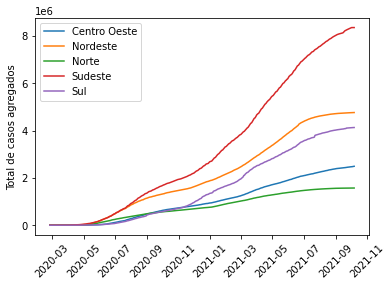

In [36]:
for i in range(5):
    plt.plot(dates,infected[i,:],label=labels[i])
plt.legend()
plt.ylabel("Total de casos agregados")
plt.xticks(rotation=45)
plt.show()

In [37]:
dim = int(np.floor(infected.shape[1]/7))
Y = np.zeros(( 5, dim)) # numero infectados na i-esima regiao na semana t 
D = np.zeros((5,dim)) # numero de mortes
for t in range(dim):
    for i in range(5):
        if t < dim - 1:
            Y[i,t] = infected[i,7*t+7] - infected[i,7*t]
            D[i,t] = np.sum(deaths[i,7*t:7*t+7])
        else:
            Y[i,t] = infected[i,-1]- infected[i,7*t]
            D[i,t] = np.sum(deaths[i,7*t:])

In [38]:
Y.shape

(5, 84)

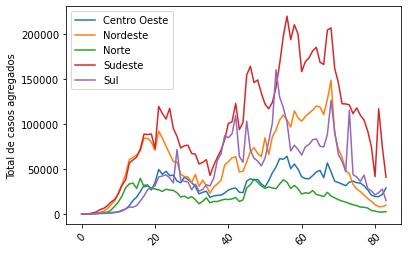

In [39]:
for i in range(5):
    plt.plot(Y[i,:],label=labels[i])
plt.legend()
plt.ylabel("Total de casos agregados")
plt.xticks(rotation=45)
plt.show()

## Make predictions with SimpleExponetial Smoothing

In [40]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [41]:
# pop_estimation/=1e3

In [42]:
n = 1
k = 3

In [43]:
Y /= 1e3
Y += 1e-8

In [44]:
pred = np.zeros(( 5, dim))
for i in range(5):
    ses_model = SimpleExpSmoothing(Y[i,:]).fit()
    pred[i,:] = ses_model.predict(start=1,end=dim)
#     model = compartmentalModel(Y[i,:],D[i,:],pop_estimation.iloc[i],44258,25260,26170,1.5,0.02,0.01)
#     pred[i,:] = model.fit_predict()[:,0]

/home/dell/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


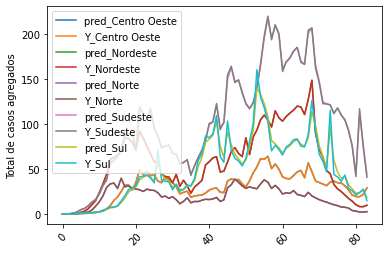

In [45]:
for i in range(5):
    plt.plot(pred[i,:],label=f"pred_{labels[i]}")
    plt.plot(Y[i,:],label=f"Y_{labels[i]}")
plt.legend()
plt.ylabel("Total de casos agregados")
plt.xticks(rotation=45)
plt.show()

In [46]:
#Constroi matriz de Adjacencias:
# 0 - Norte
# 1 - Centro Oeste
# 2 - Nordeste
# 3 - Sudeste
# 4 - Sul
# A = np.zeros((5,5))
# A[0,0] = A[0,1] = A[0,2] = A[1,0] = A[2,0] = 1
# A[1,1] = A[1,2] = A[1,3] = A[1,4] = A[2,1] = A[3,1] = A[4,1] = 1
# A[2,2] = A[2,3] = A[3,2] = 1
# A[3,3] = A[3,4] = A[4,3] = 1
# A[4,4] = 1

In [47]:
def make_constraints(Y,pred=[],use_preds=False):
    shape = Y.shape
    Y_hat = cp.Variable(shape)
    C = [cp.Variable((shape[0],shape[0])) for i in range(k)]
    C.append(cp.Variable((shape[0],shape[0])))
    constraints = []
    for i in range(shape[0]):
         for t in range(shape[1]-n):
            terms = []
            for j in range(shape[0]):
                for l in range(min(t,k)):     
                    terms.append(C[l][i,j]*Y[j,t-l])
                if use_preds and (len(pred) >0):
                    terms.append(C[k][i,j]*pred[j,t+n]) # termo que depende das previsoes do compartmental model
            constraints += [Y_hat[i,t+n] == cp.sum(terms)]
    return constraints,C,Y_hat

In [68]:
def make_plot_Y(Y,Y_hat,lambda_):
    for i in range(Y.shape[0]):
        plt.plot(abs(Y[i,:] - Y_hat.value[i,:]),label=labels[i])
    plt.legend()
    plt.ylabel("predict vs real")
    plt.xticks(rotation=45)
    text = f"\n Total MAE: {np.mean(np.abs(Y - Y_hat.value)) :.2f}"
    plt.title(text)
    plt.savefig(f"errors_lambda_{lambda_}.png")
    plt.show()

In [56]:
def make_plot_C(C,lambda_):
    a = np.array([C[i].value for i in range(k)])
    plt.hist(a.flat)
    plt.title(f"Distribution of parameters for $\lambda$={lambda_}")
    plt.show()

In [57]:
def make_plot_C_3d(C,lambda_,show_SES=True):
    bins = np.linspace(-1.5, 1.5, 25)
    for i in range(len(C)):
        a = C[i].value
        if i < 3:
            plt.hist(a.flat,bins,alpha=0.5,label=f"lag = {i+1}")
        elif show_SES:
            plt.hist(a.flat,bins,alpha=0.5,label=f"SES")
    plt.title(f"Distribution of parameters for $\lambda$={lambda_} over time")
    plt.legend()
    plt.savefig(f"dist_time_lambda_{lambda_}.png")
    plt.show()

In [58]:
def loop_inplace_sum(arrlist):
    # assumes len(arrlist) > 0
    sum_ = arrlist[0].value.copy()
    for a in arrlist[1:]:
        sum_ += a.value
    return sum_

In [62]:
def make_plot_C_dependencias(C):
    bins = np.linspace(-1.5, 1.5, 25)
    agg = loop_inplace_sum(C)
    # Position of bars on x-axis
    ind = np.arange(agg.shape[0])
    # Figure size
    plt.figure(figsize=(10,5))
    # Width of a bar 
    width = 0.15       
    # Plotting
    for i in range(agg.shape[0]):
        position = ind + (width*(1-agg.shape[0])/2) + i*width
        plt.bar(position, agg[i,:], width=width, label=f'{labels[i]}')
    plt.xlabel('Regioes i')
    plt.ylabel('Influencia total da regiao i em j')
    # xticks()
    # First argument - A list of positions at which ticks should be placed
    # Second argument -  A list of labels to place at the given locations
    plt.xticks(ind + width / 2, labels[:agg.shape[0]])
    # Finding the best position for legends and putting it
    plt.legend(loc='best')
    plt.show()

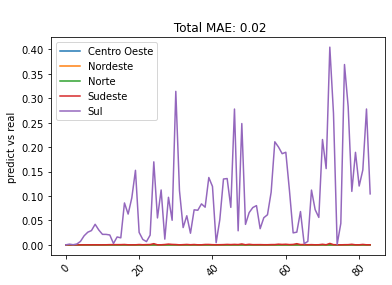

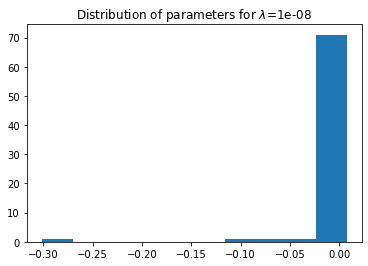

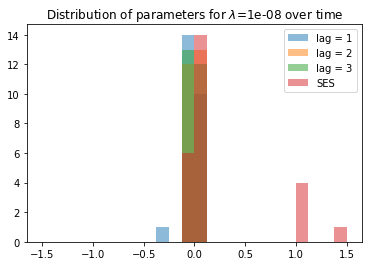

------------------------


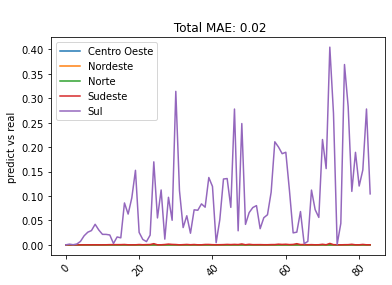

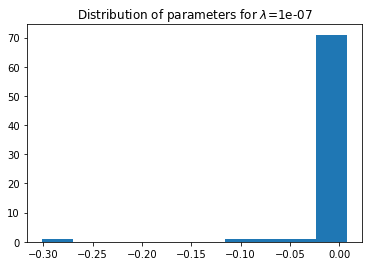

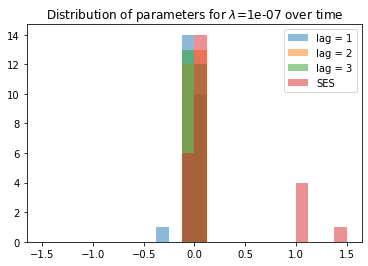

------------------------


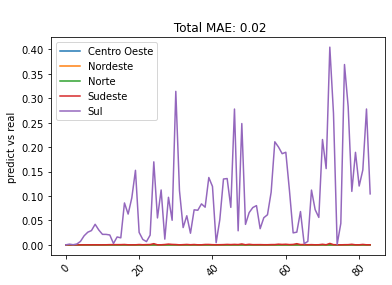

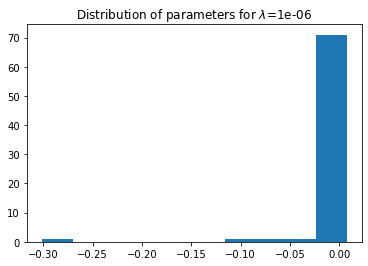

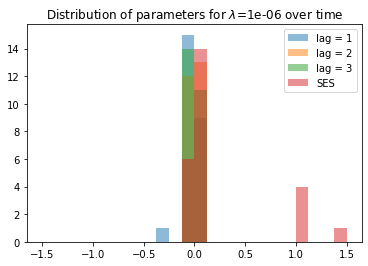

------------------------


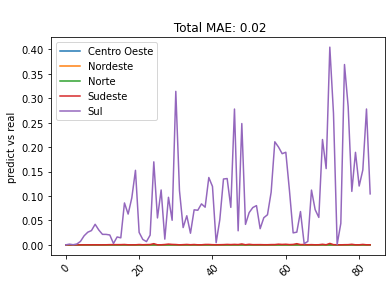

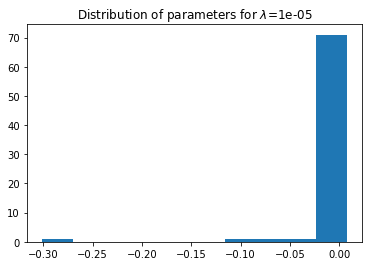

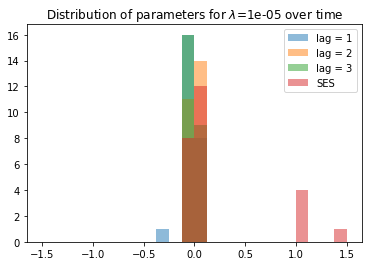

------------------------


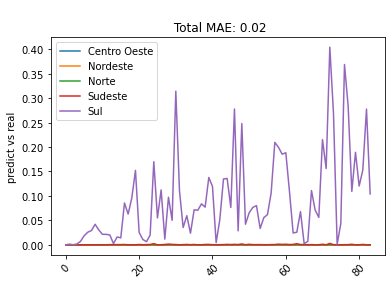

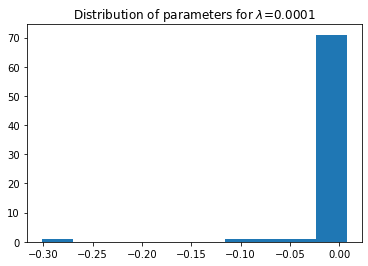

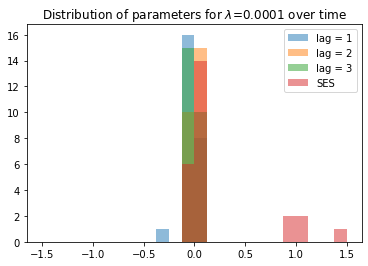

------------------------


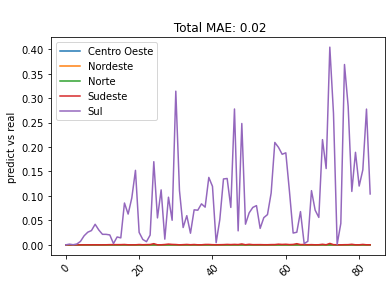

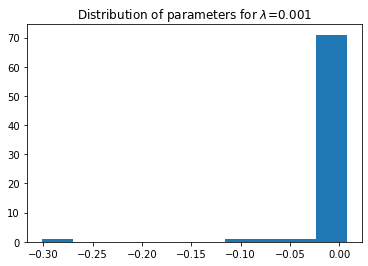

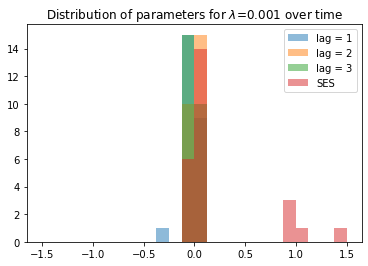

------------------------


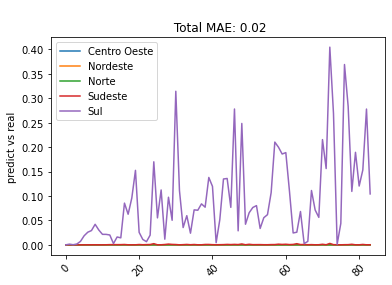

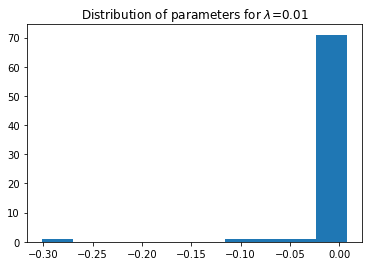

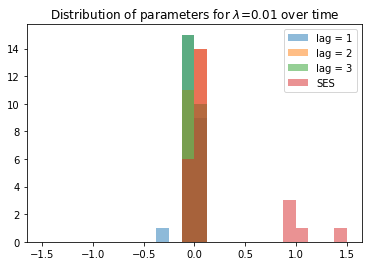

------------------------


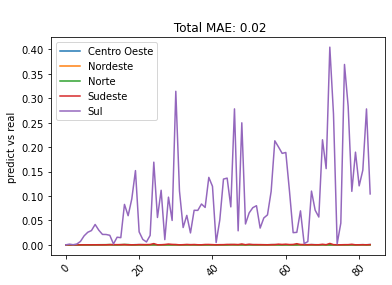

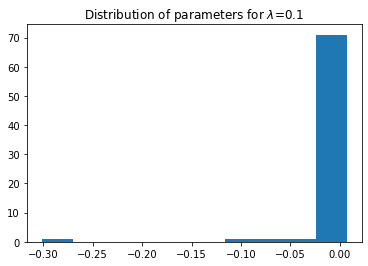

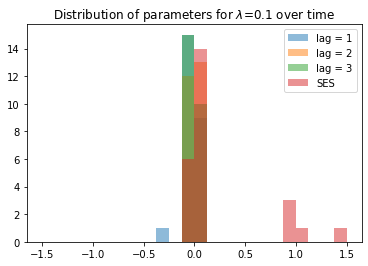

------------------------


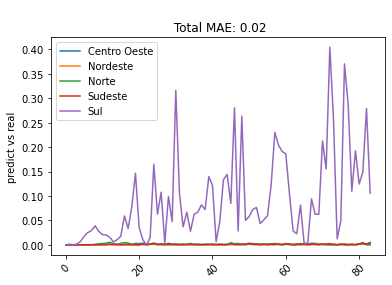

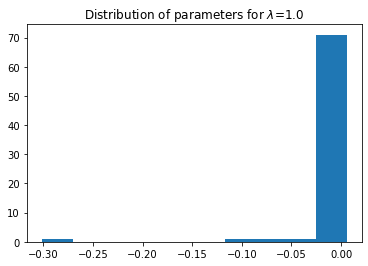

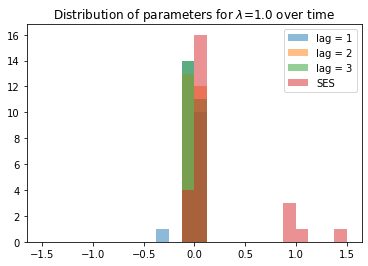

------------------------


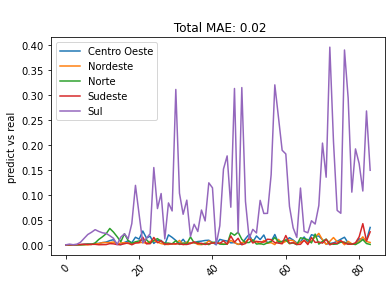

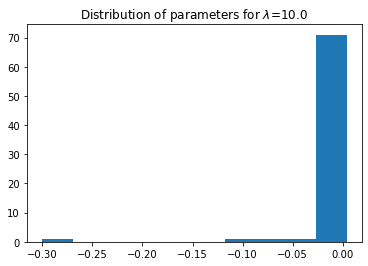

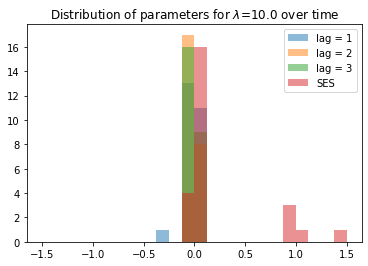

------------------------


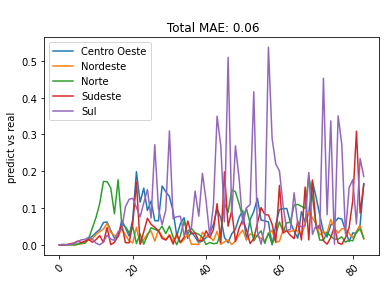

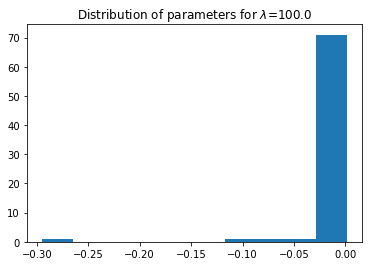

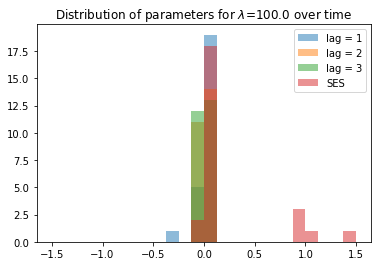

------------------------


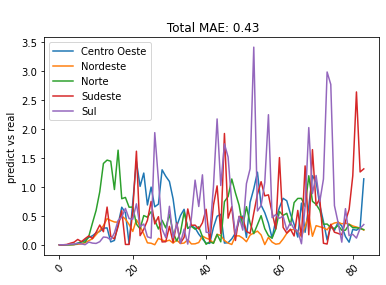

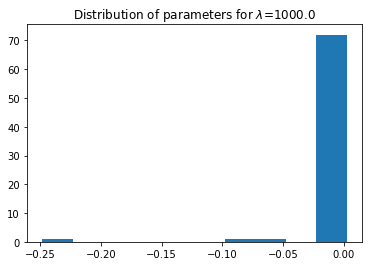

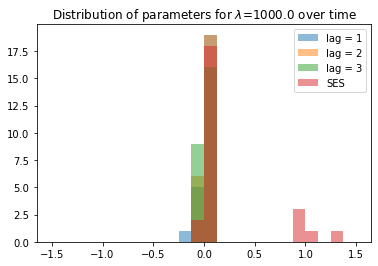

------------------------


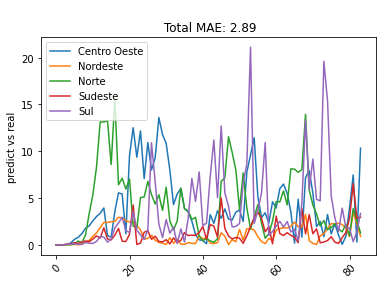

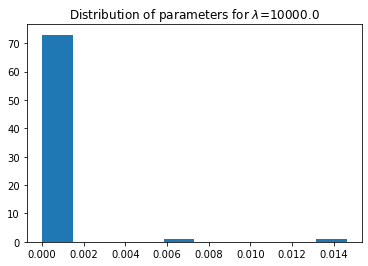

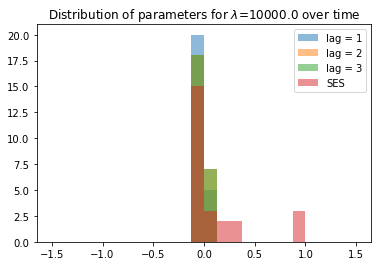

------------------------


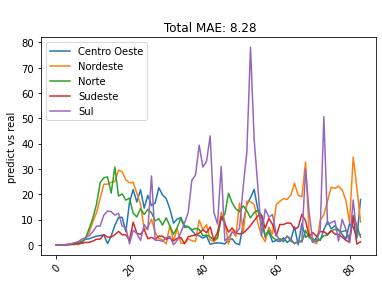

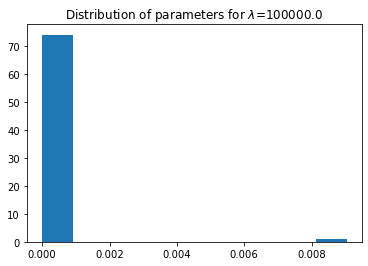

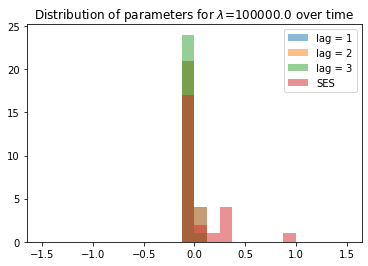

------------------------


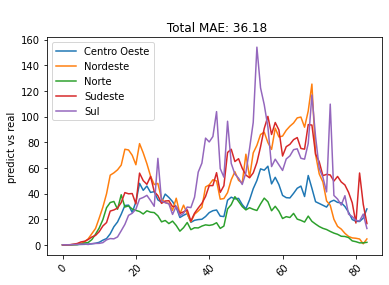

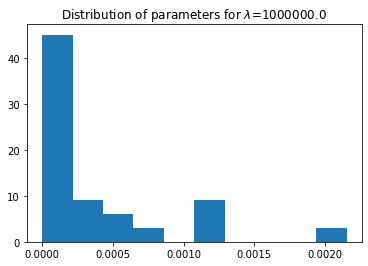

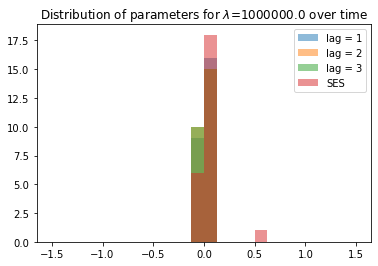

------------------------


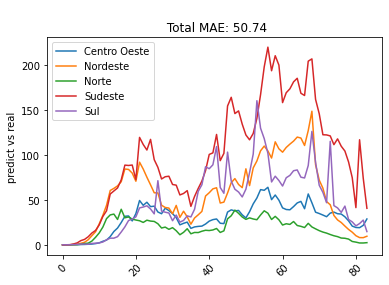

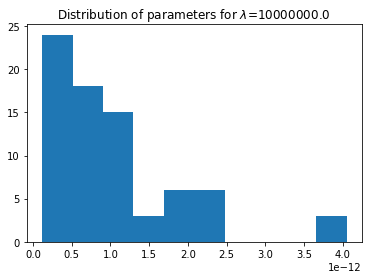

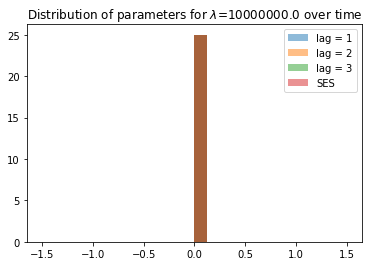

------------------------


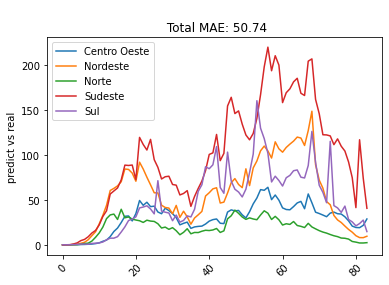

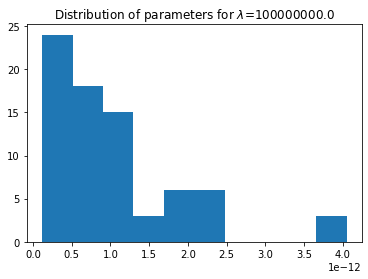

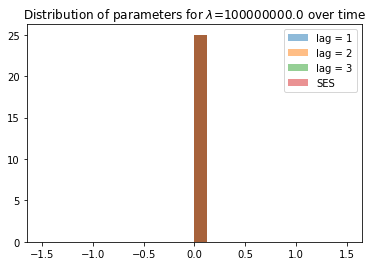

------------------------


In [63]:
with_preds = []
with_preds_mse = []
lambdas = np.logspace(-8,8,17)
for lambda_ in lambdas:
    constraints,C,Y_hat = make_constraints(Y.copy(),pred,True)
    obj = cp.Minimize(cp.sum_squares(Y_hat - Y) + lambda_*cp.norm1(cp.hstack(C)))
    p = cp.Problem(obj,constraints)
    p.solve()
    with_preds.append(np.mean(np.abs(Y - Y_hat.value)))
    with_preds_mse.append(np.mean((Y-Y_hat.value)**2))
    make_plot_Y(Y,Y_hat,lambda_)
    make_plot_C(C,lambda_)
    make_plot_C_3d(C,lambda_)
    print("------------------------")

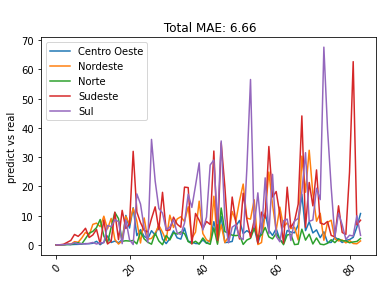

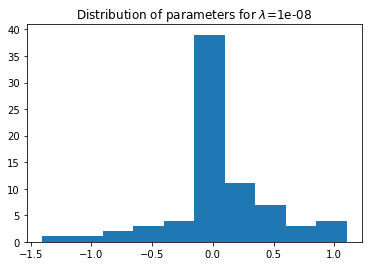

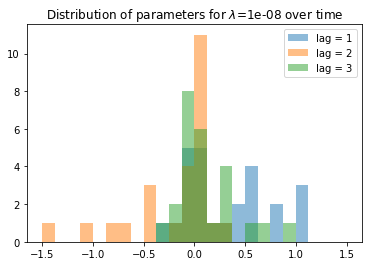

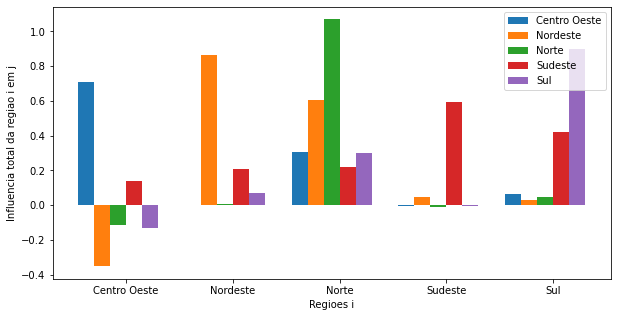

------------------------


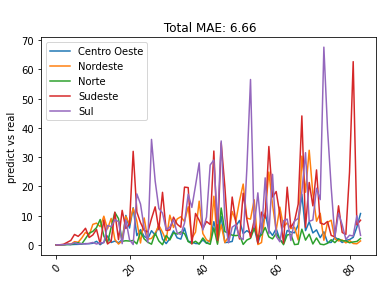

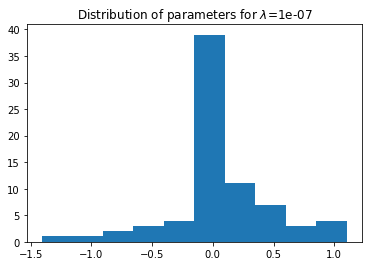

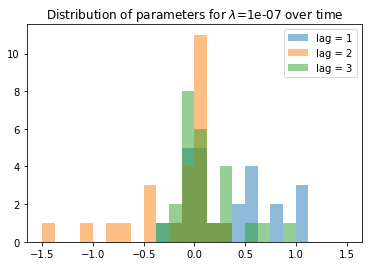

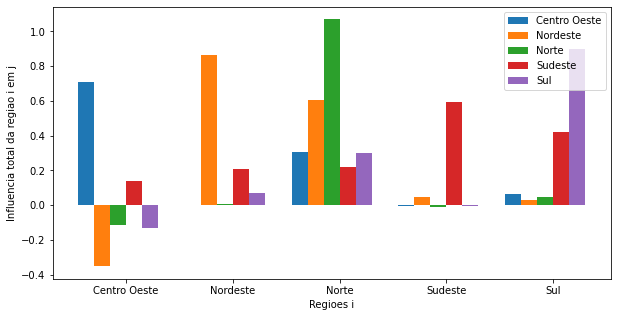

------------------------


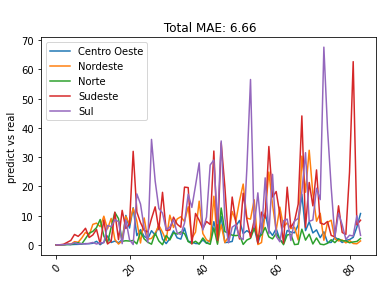

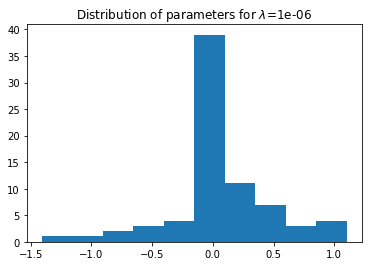

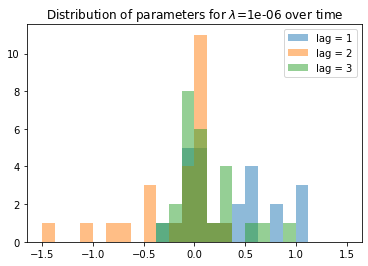

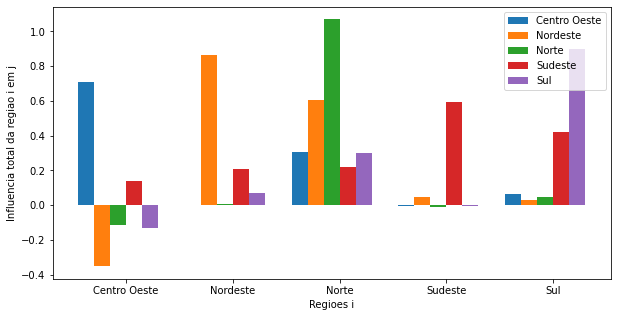

------------------------


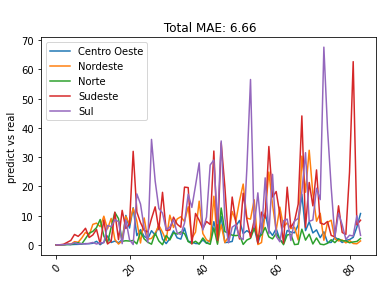

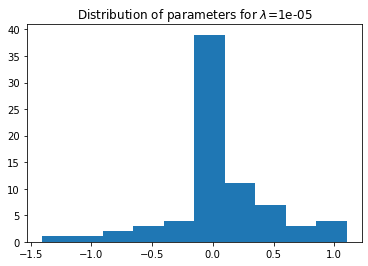

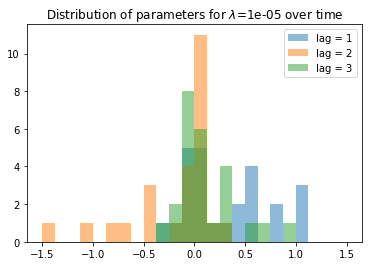

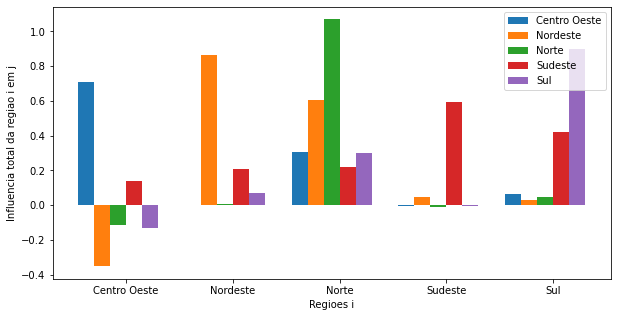

------------------------


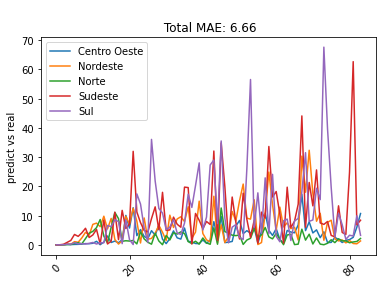

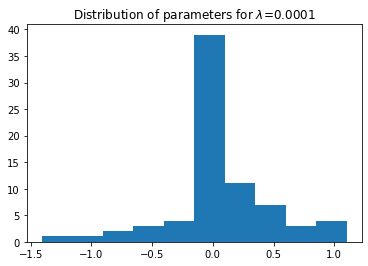

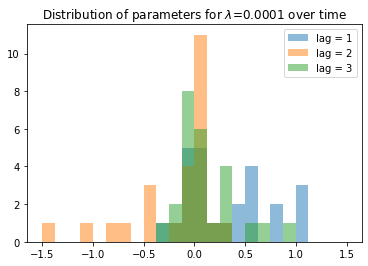

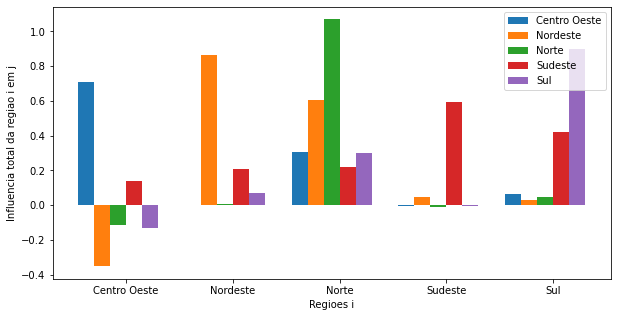

------------------------


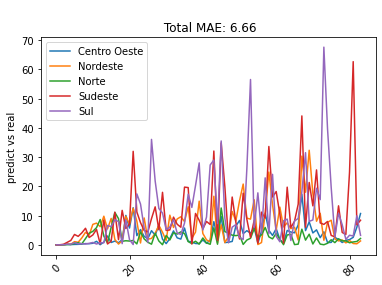

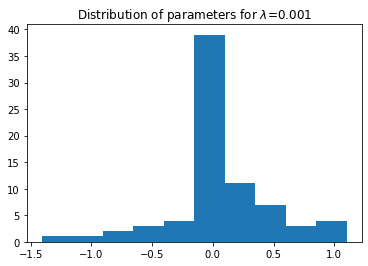

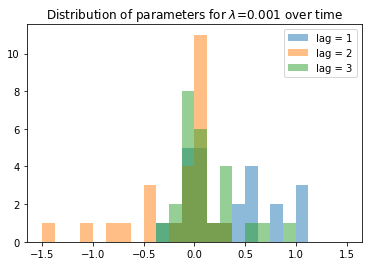

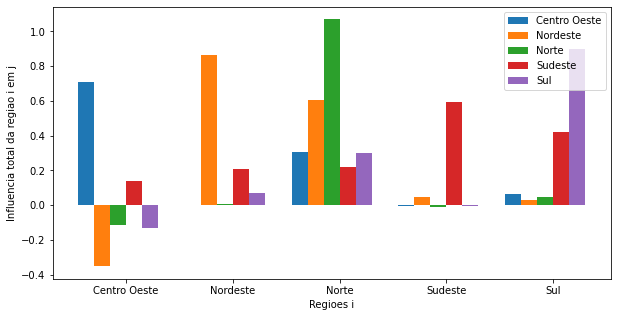

------------------------


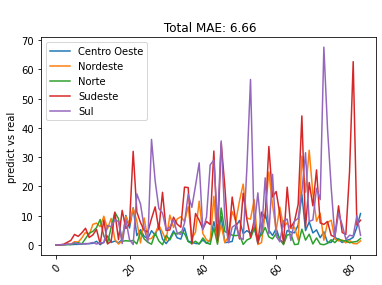

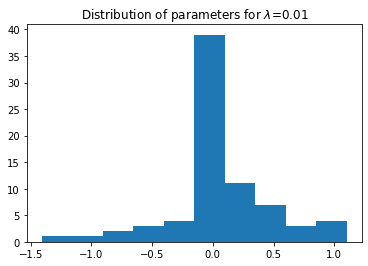

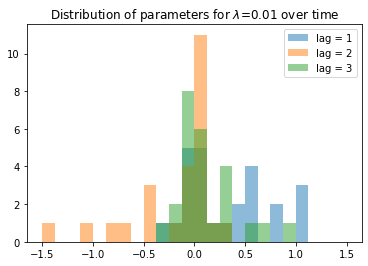

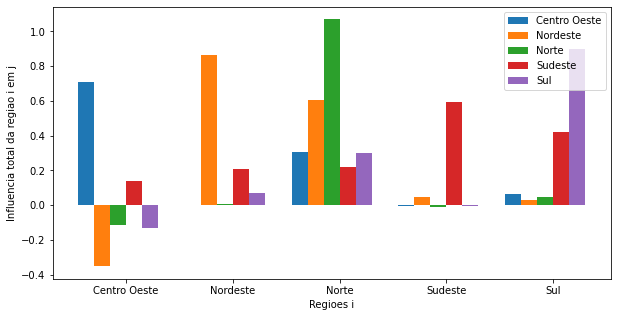

------------------------


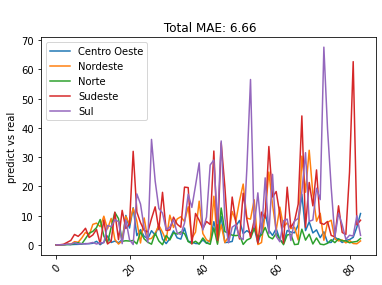

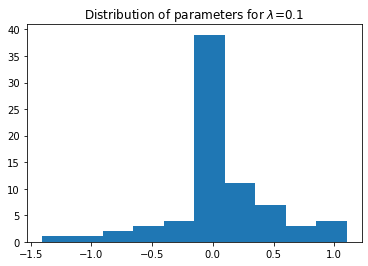

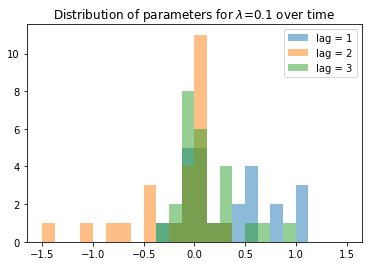

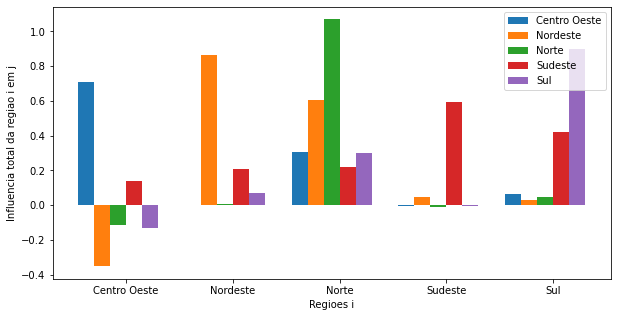

------------------------


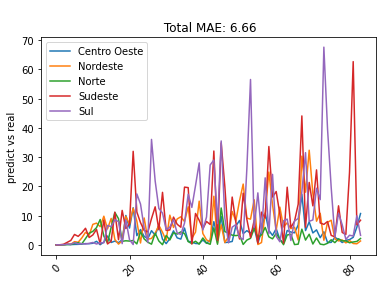

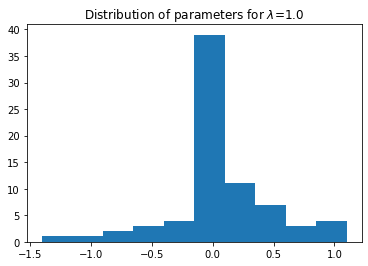

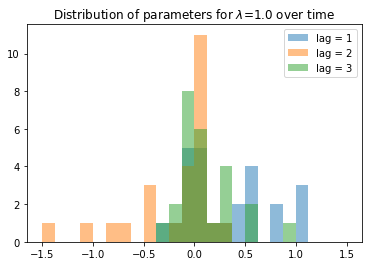

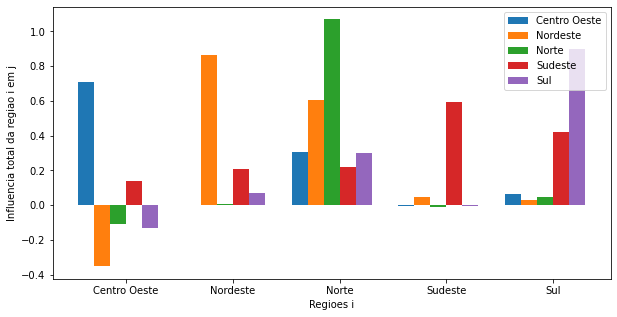

------------------------


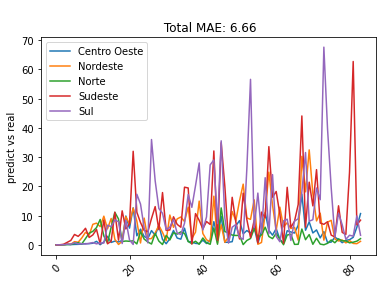

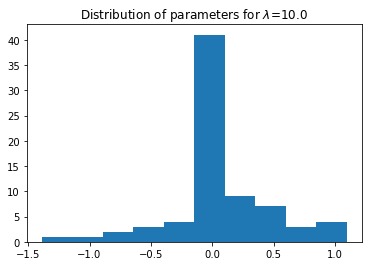

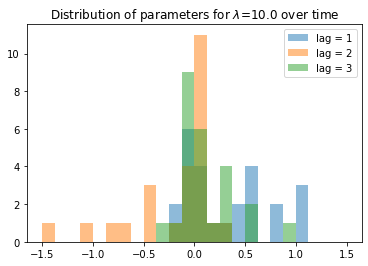

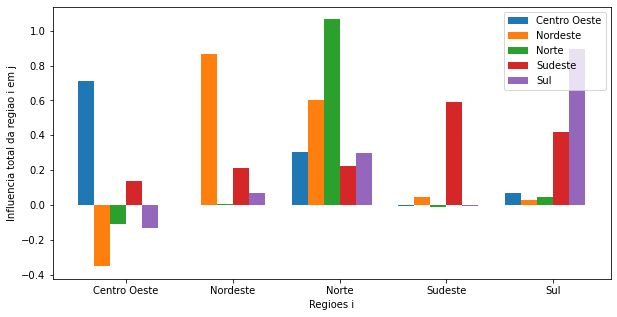

------------------------


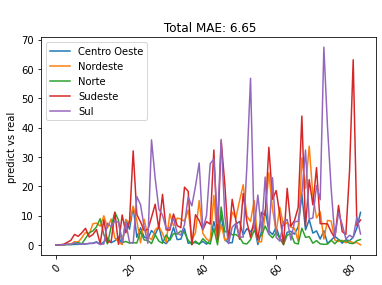

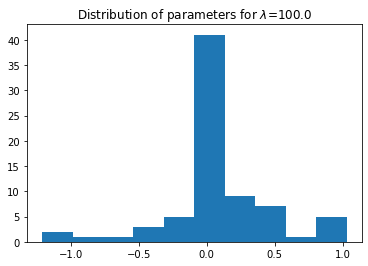

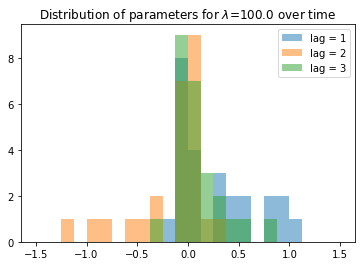

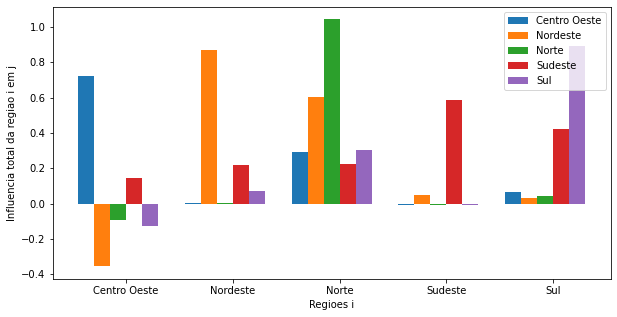

------------------------


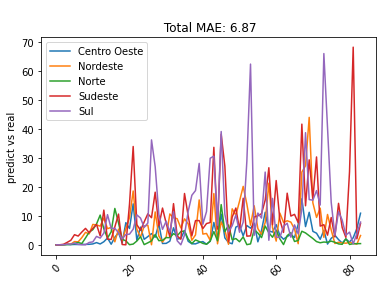

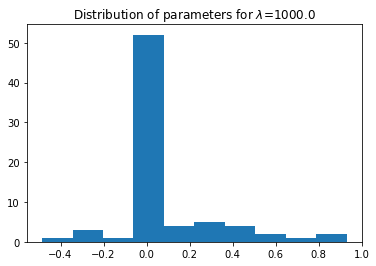

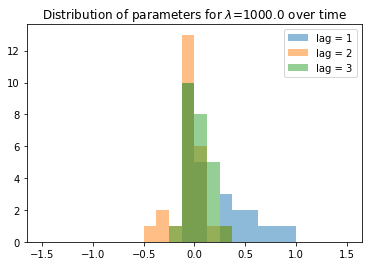

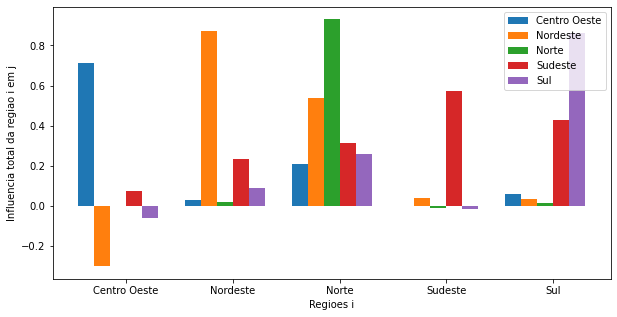

------------------------


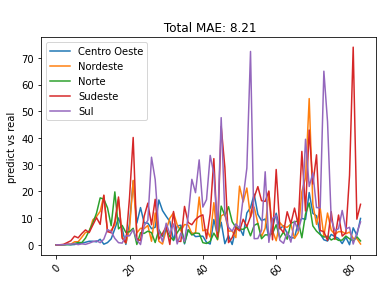

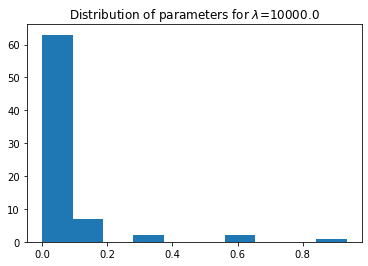

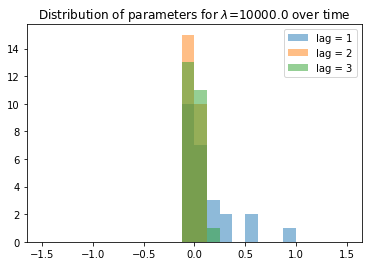

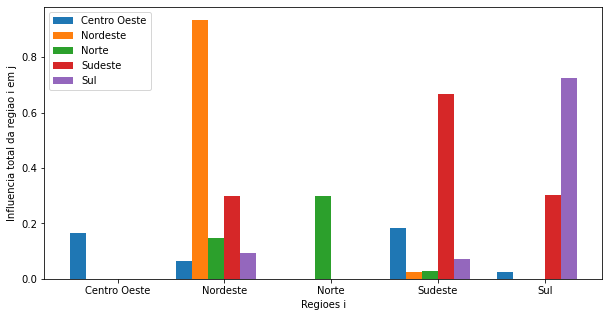

------------------------


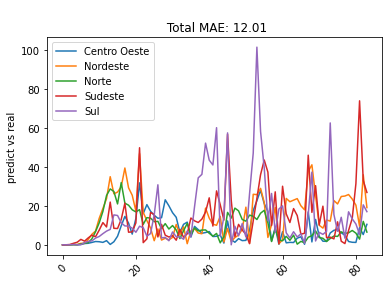

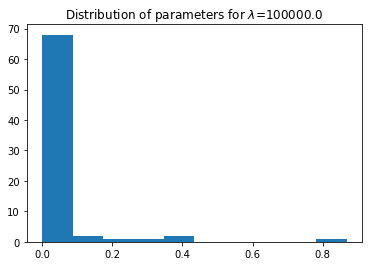

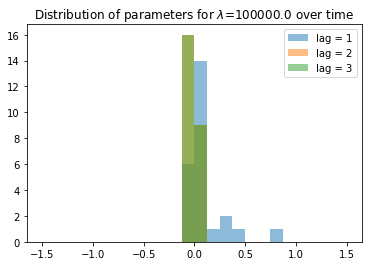

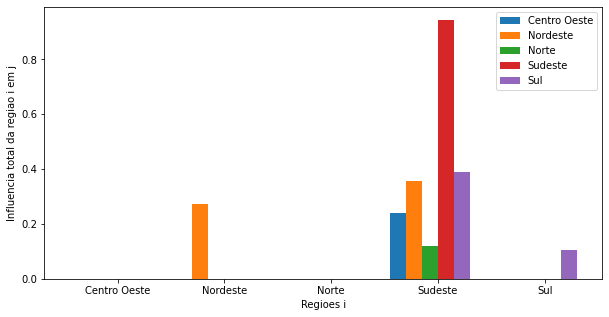

------------------------


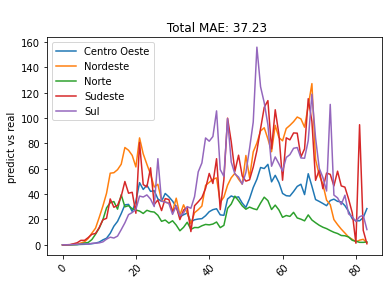

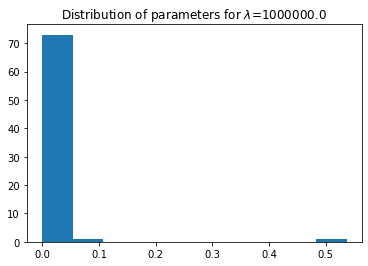

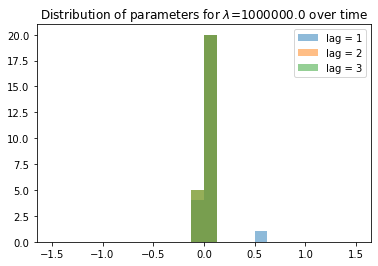

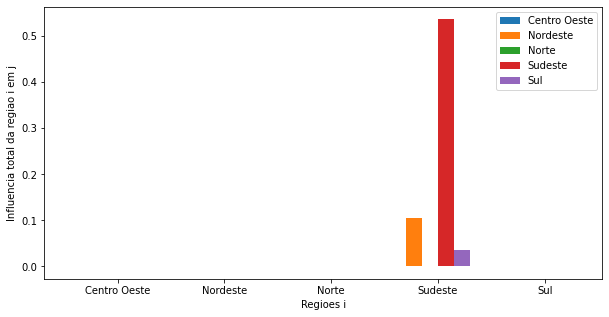

------------------------


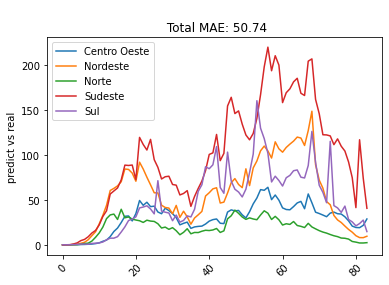

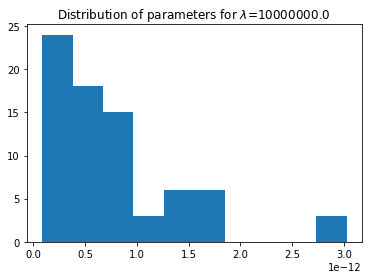

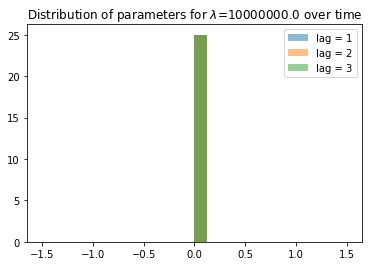

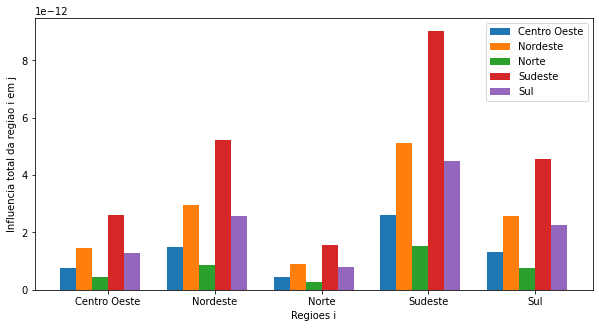

------------------------


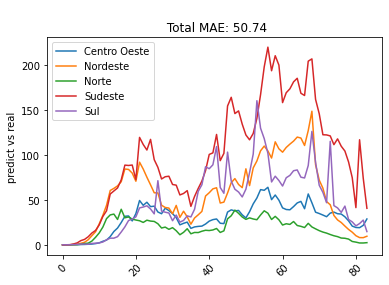

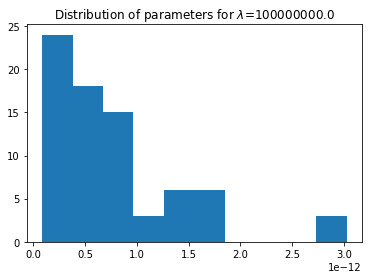

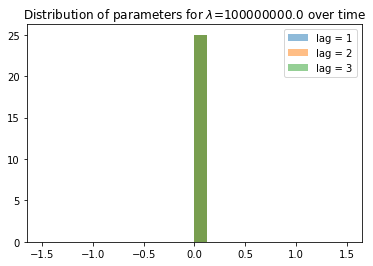

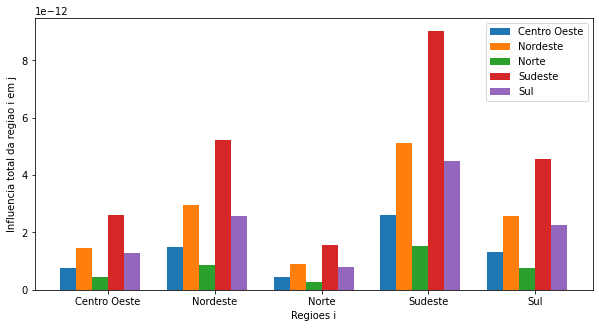

------------------------


In [64]:
no_preds = []
no_preds_mse = []
lambdas = np.logspace(-8,8,17)
for lambda_ in lambdas:
    constraints,C,Y_hat = make_constraints(Y.copy())
    obj = cp.Minimize(cp.sum_squares(Y_hat - Y) + lambda_*cp.norm1(cp.hstack(C)))
    p = cp.Problem(obj,constraints)
    p.solve()
    no_preds.append(np.mean(np.abs(Y - Y_hat.value)))
    no_preds_mse.append(np.mean((Y-Y_hat.value)**2))
    make_plot_Y(Y,Y_hat,lambda_)
    make_plot_C(C,lambda_)
    make_plot_C_3d(C,lambda_,False)
    make_plot_C_dependencias(C)
    print("------------------------")

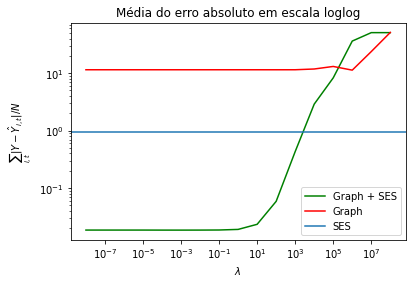

In [79]:
plt.plot(lambdas,with_preds,label="Graph + SES",color="g")
plt.plot(lambdas,no_preds,label="Graph",color="r")
plt.axhline(np.mean(np.abs(Y - pred)),label="SES")
plt.xlabel("$\lambda$")
plt.ylabel("$\sum_{i,t} |Y - \hat{Y}_{i,t}|/N$")
plt.title("Média do erro absoluto em escala loglog")
plt.legend()
plt.loglog()
plt.show()

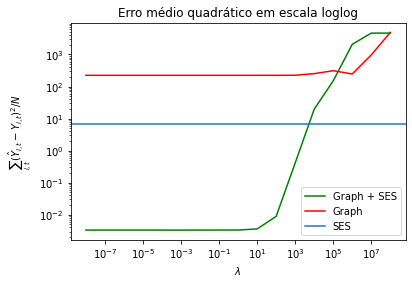

In [78]:
plt.plot(lambdas,with_preds_mse,label="Graph + SES",color="g")
plt.plot(lambdas,no_preds_mse,label="Graph",color="r")
plt.axhline(np.mean((pred-Y)**2),label="SES")
plt.xlabel("$\lambda$")
plt.ylabel("$\sum_{i,t} (\hat{Y}_{i,t} - Y_{i,t})^2/N$")
plt.title("Erro médio quadrático em escala loglog")
plt.legend()
plt.loglog()
plt.show()

## Hierarchical model

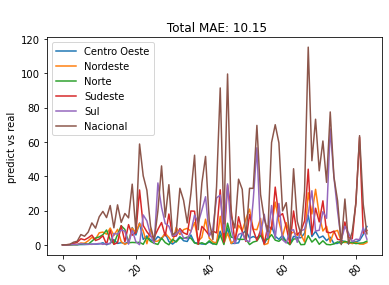

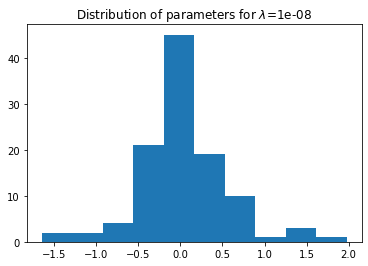

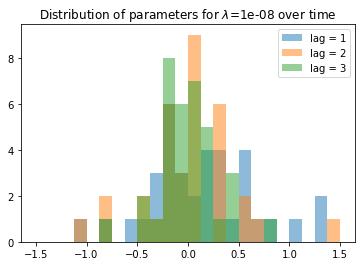

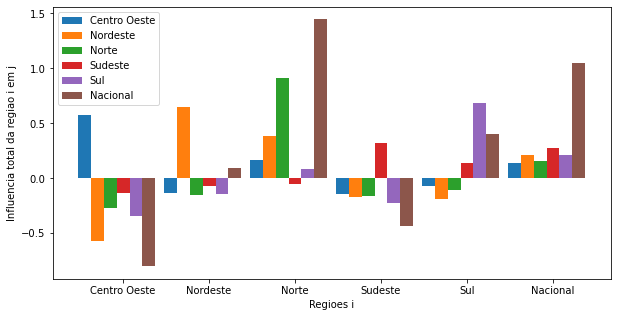

------------------------


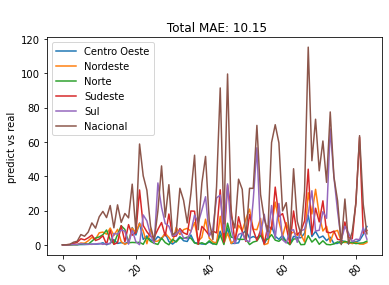

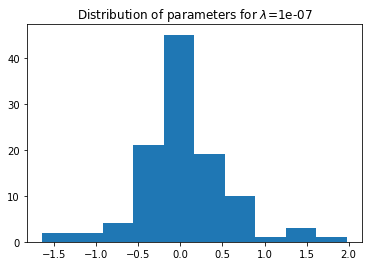

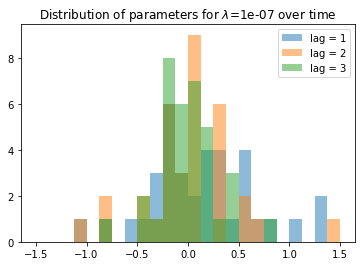

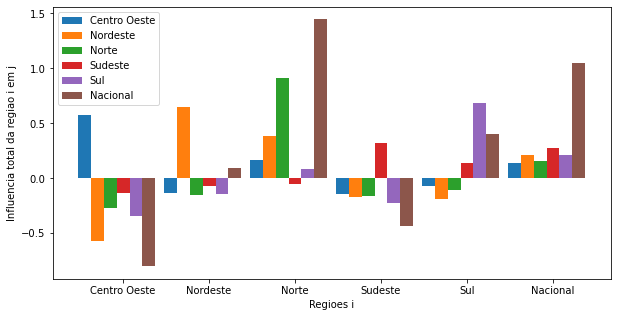

------------------------


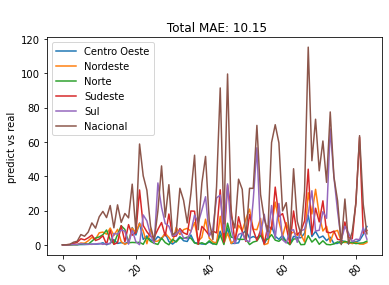

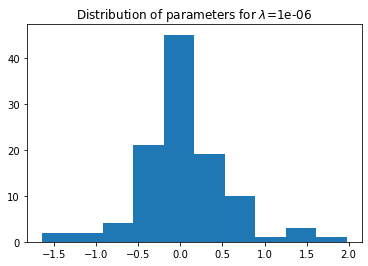

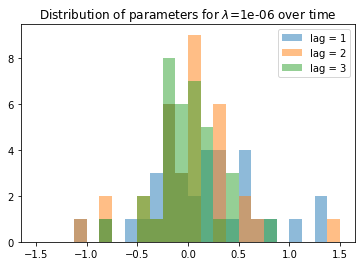

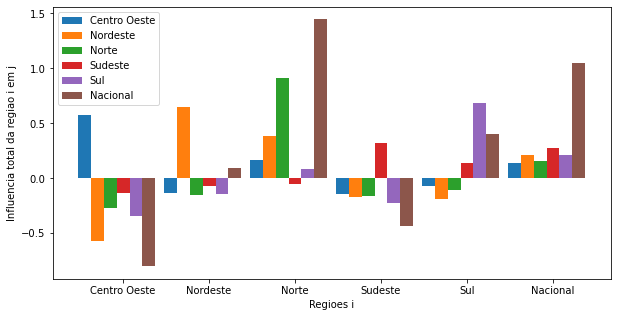

------------------------


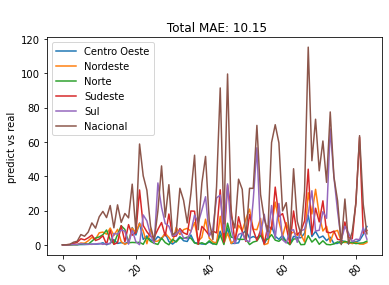

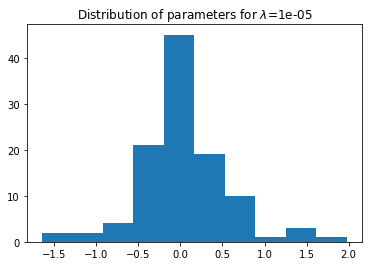

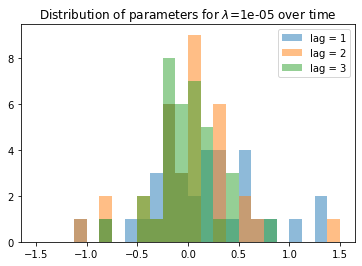

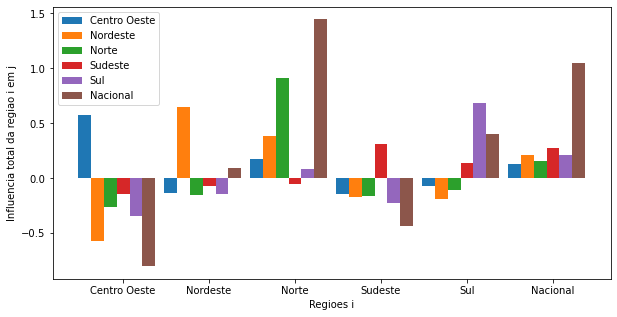

------------------------


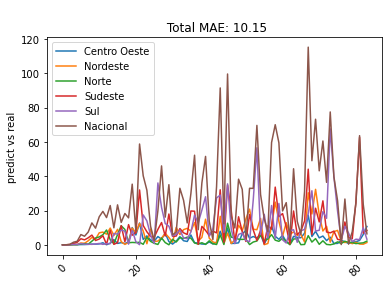

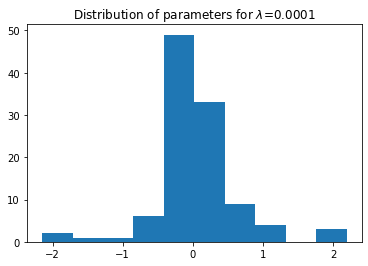

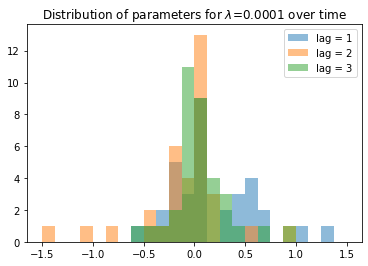

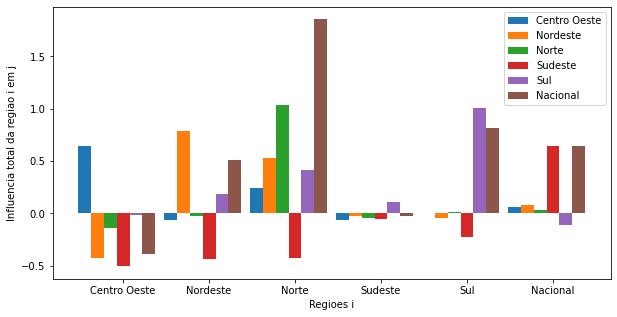

------------------------


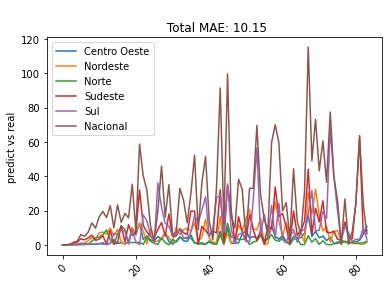

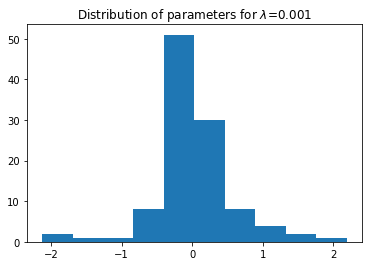

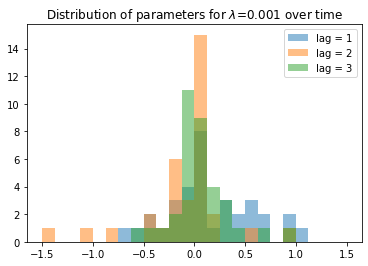

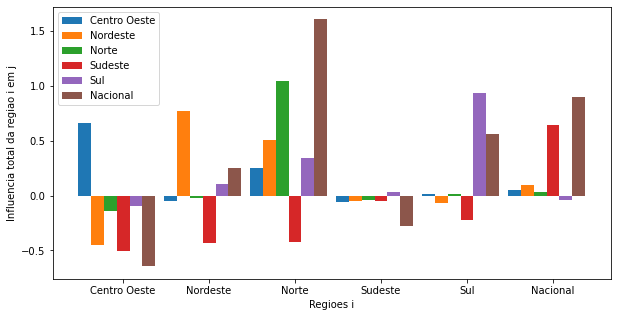

------------------------


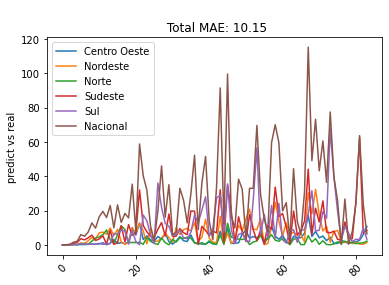

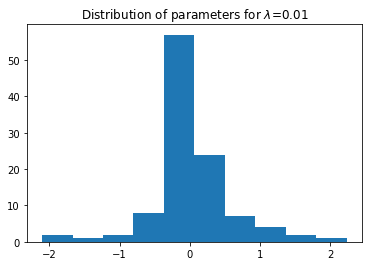

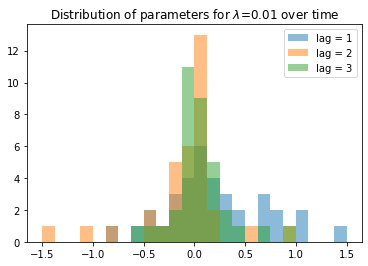

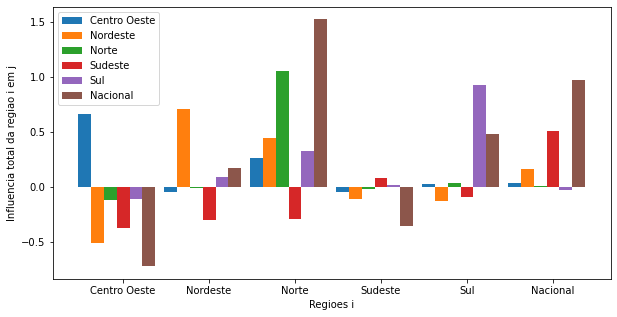

------------------------


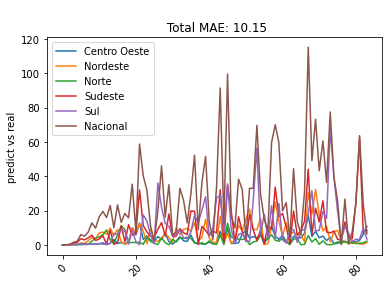

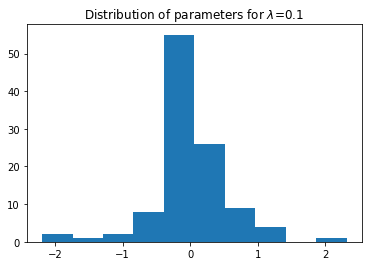

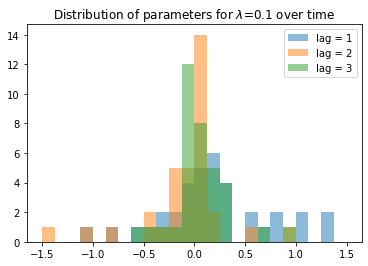

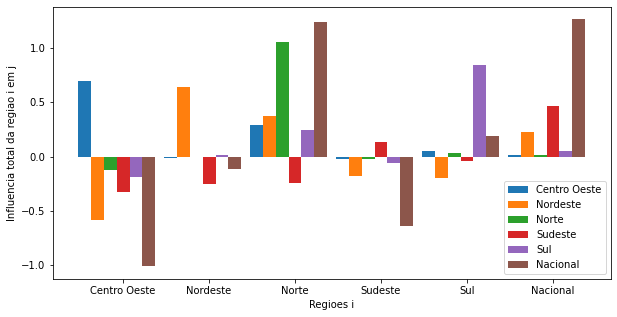

------------------------


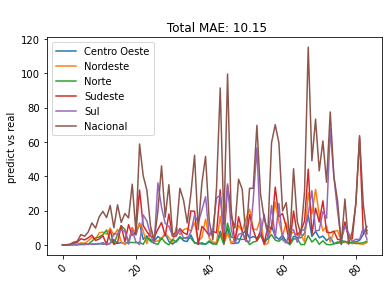

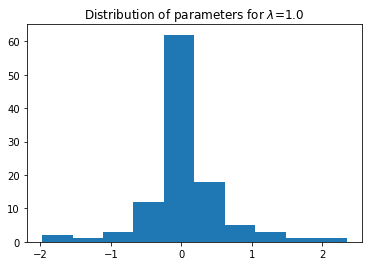

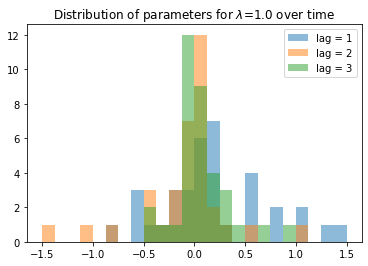

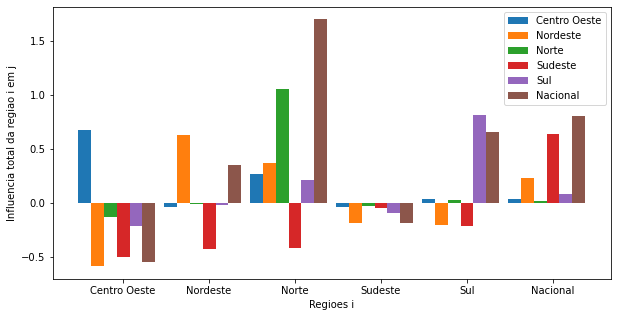

------------------------


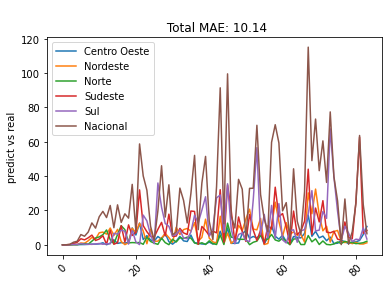

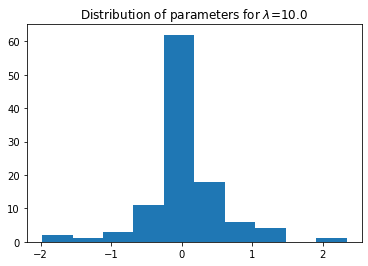

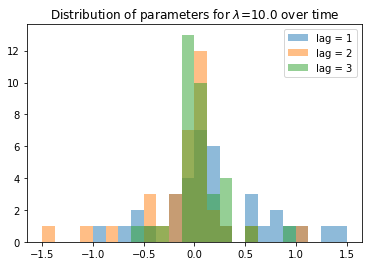

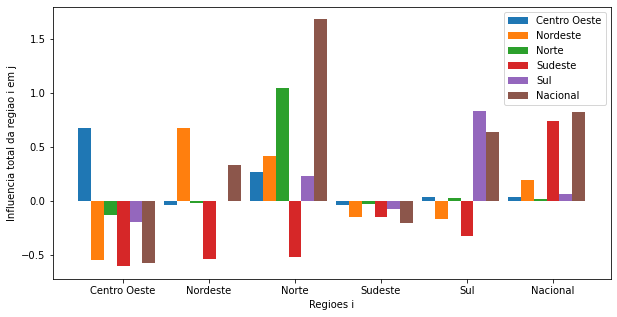

------------------------


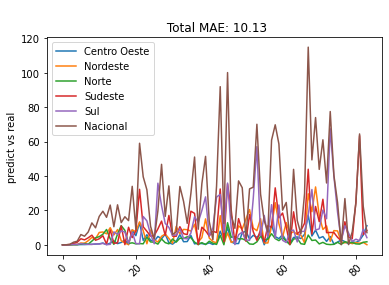

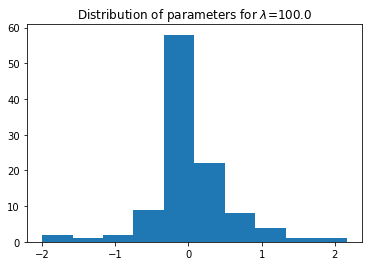

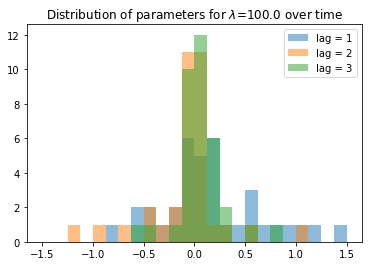

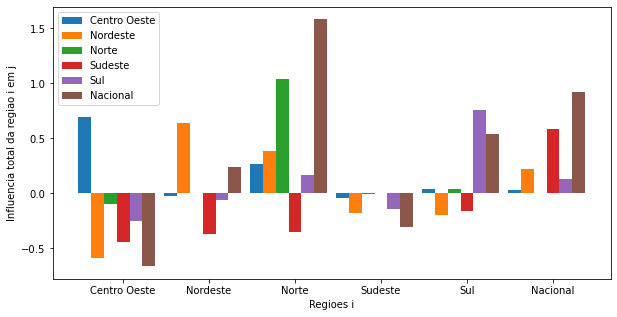

------------------------


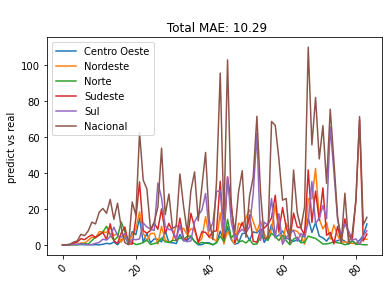

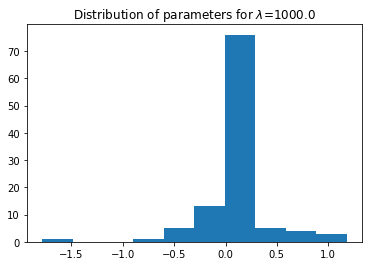

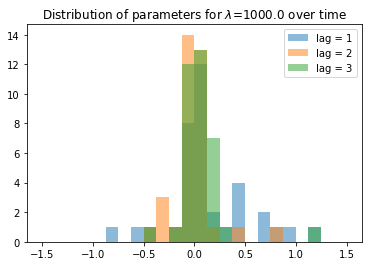

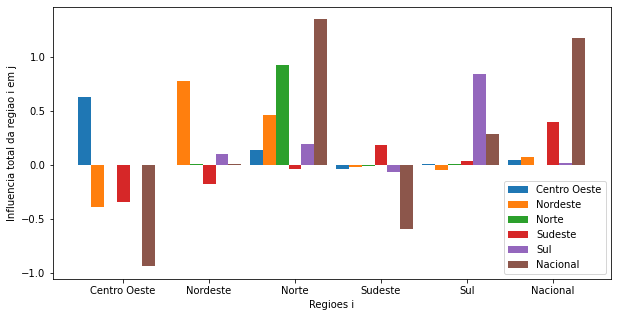

------------------------


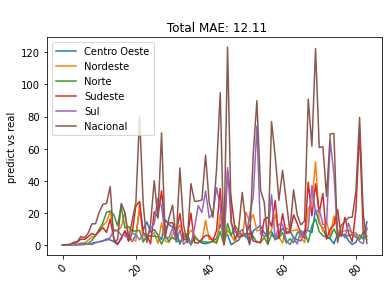

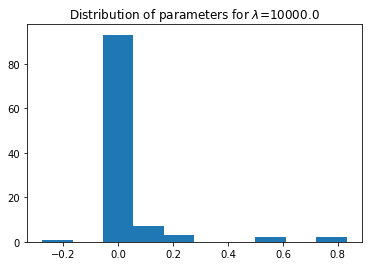

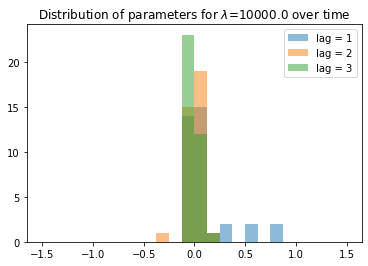

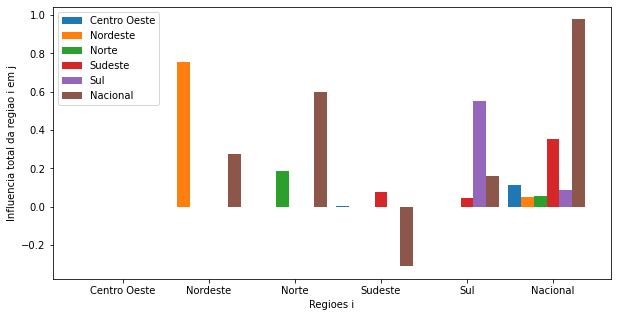

------------------------


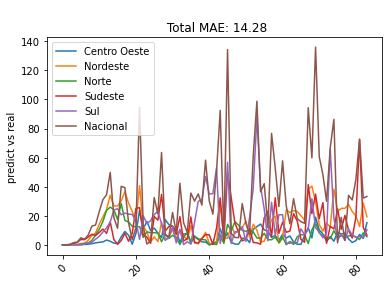

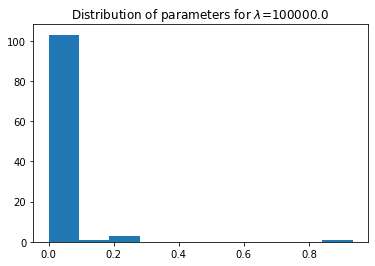

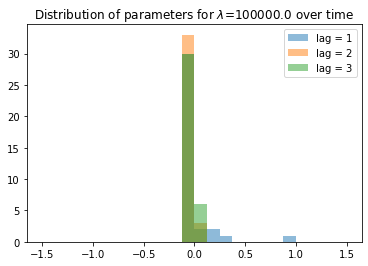

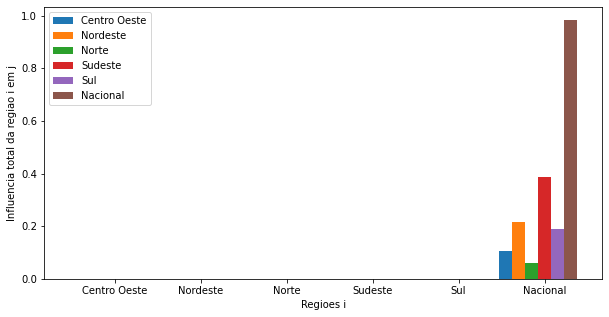

------------------------


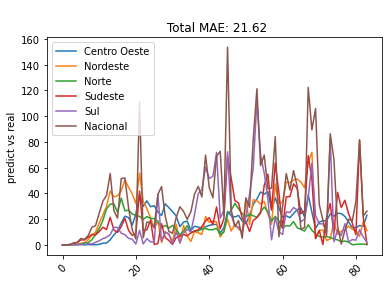

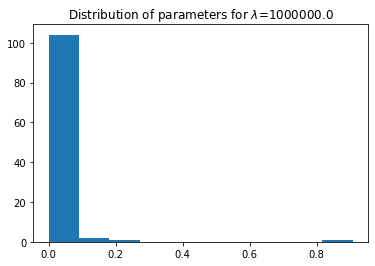

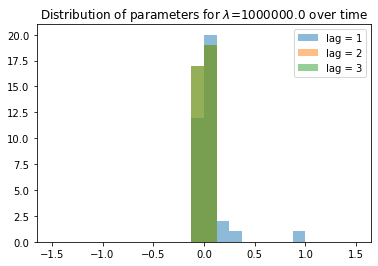

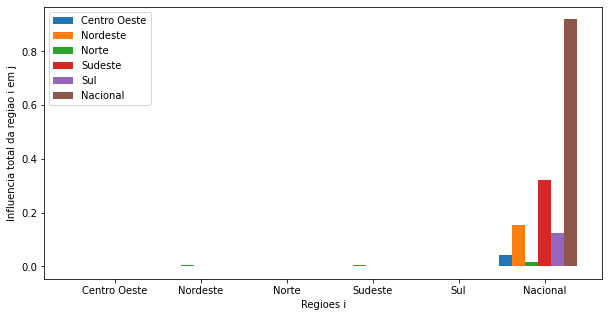

------------------------


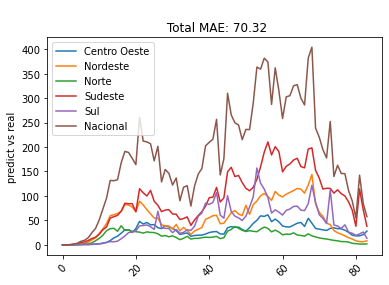

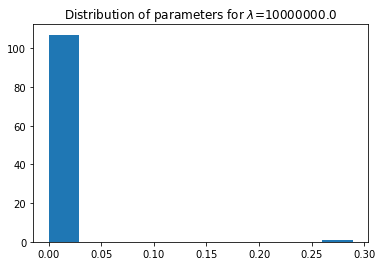

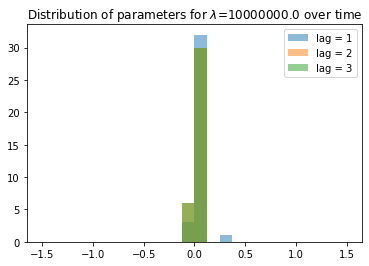

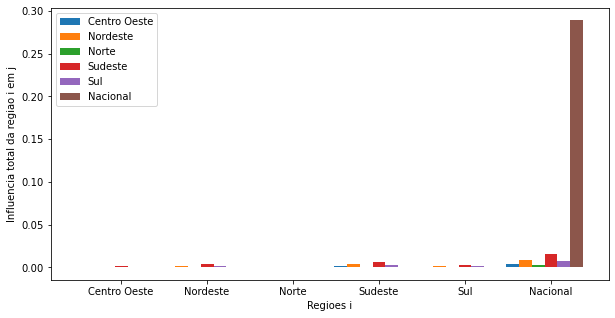

------------------------


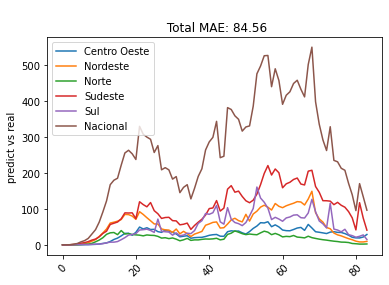

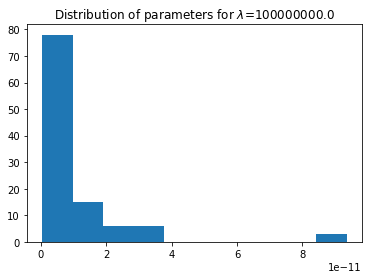

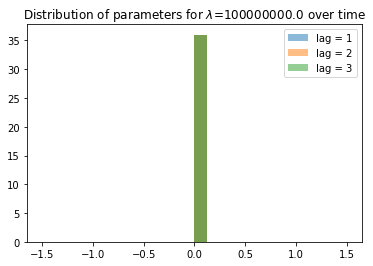

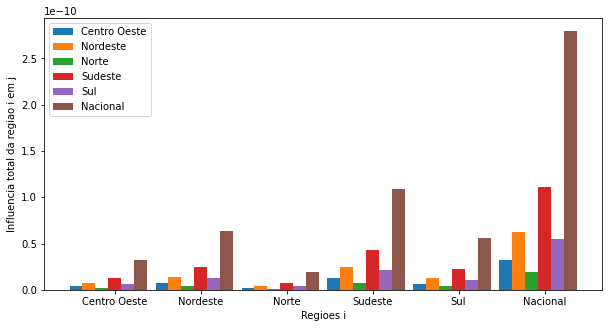

------------------------


In [74]:
no_preds = []
no_preds_mse = []
for lambda_ in lambdas:
    Y_nacional = np.vstack([Y.copy(),np.sum(Y,axis=0)])
    constraints,C,Y_hat = make_constraints(Y_nacional.copy())
    obj = cp.Minimize(cp.sum_squares(Y_hat - Y_nacional) + lambda_*cp.norm1(cp.hstack(C)))
    p = cp.Problem(obj,constraints)
    p.solve()
    no_preds.append(np.mean(np.abs(Y_nacional - Y_hat.value)))
    no_preds_mse.append(np.mean((Y_nacional - Y_hat.value)**2))
    make_plot_Y(Y_nacional,Y_hat,lambda_)
    make_plot_C(C,lambda_)
    make_plot_C_3d(C,lambda_,False)
    make_plot_C_dependencias(C)
    print("------------------------")

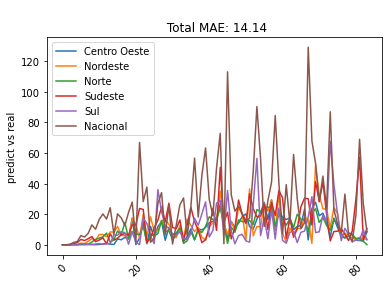

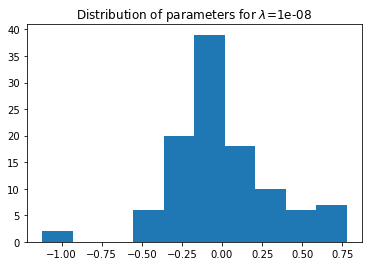

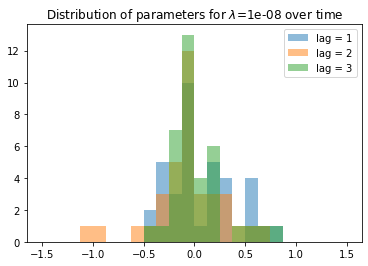

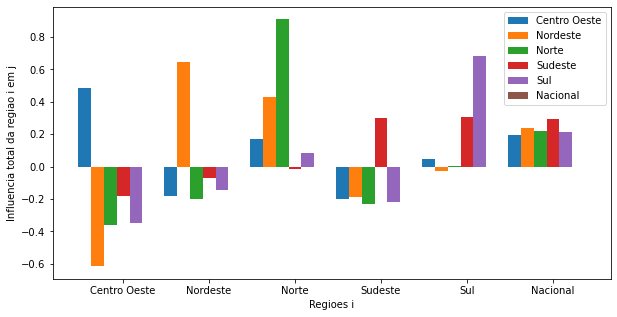

------------------------


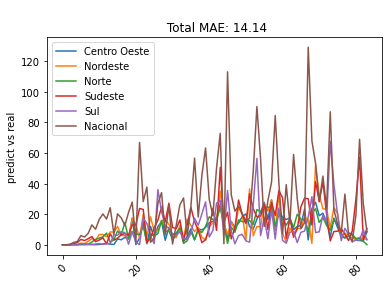

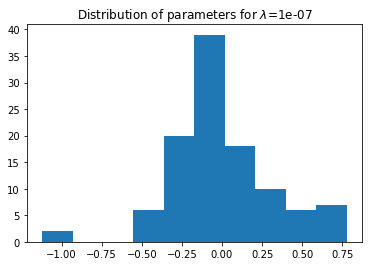

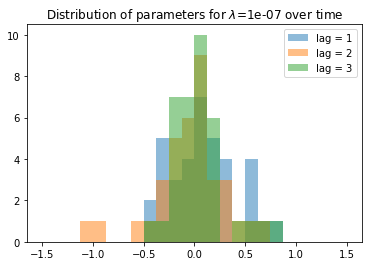

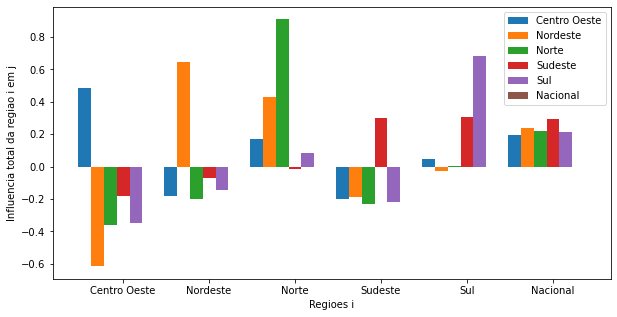

------------------------


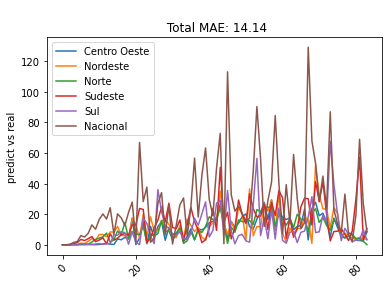

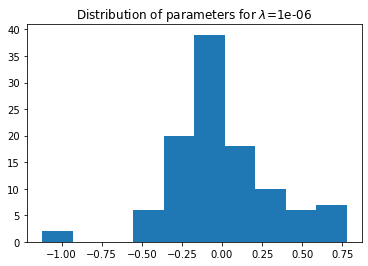

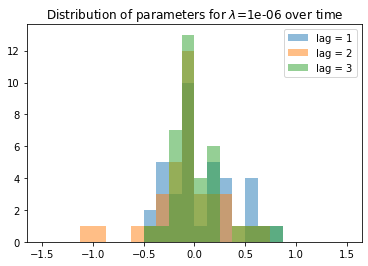

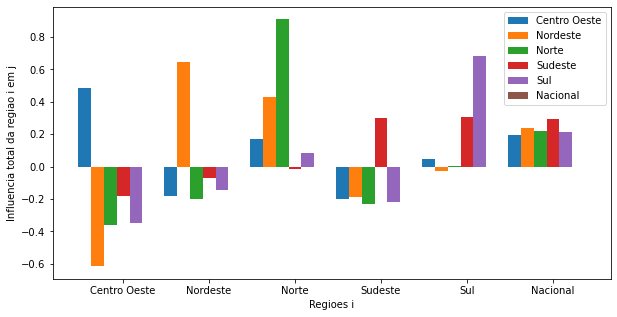

------------------------


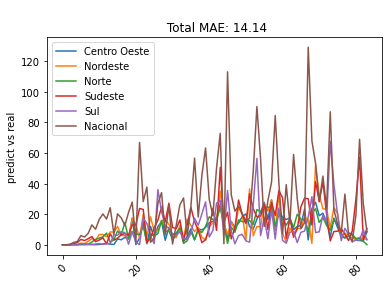

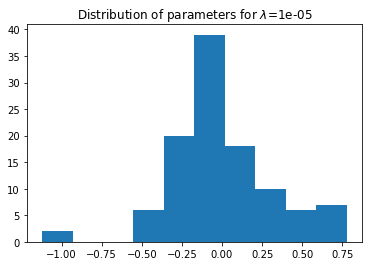

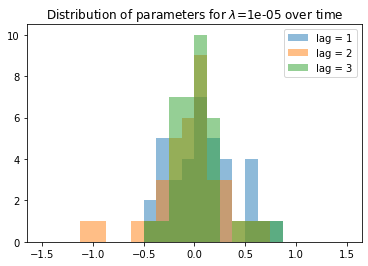

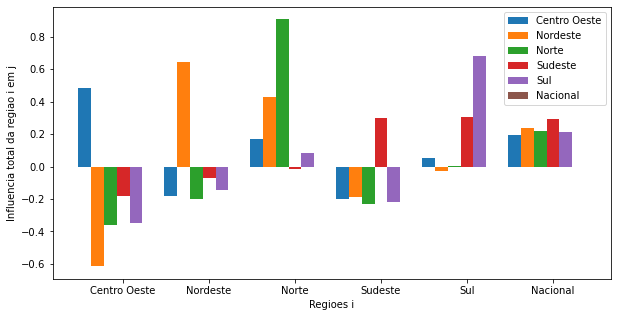

------------------------


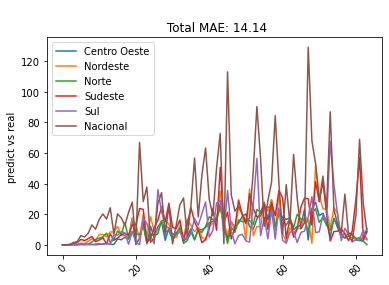

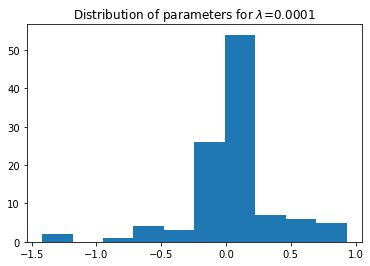

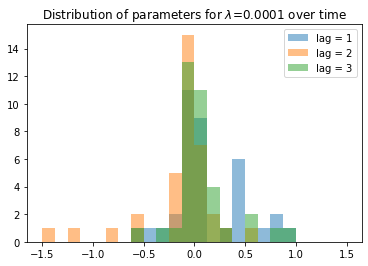

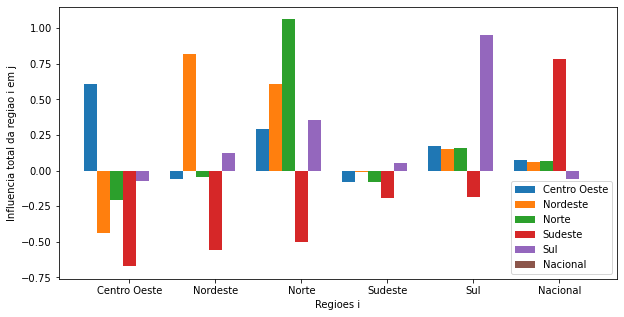

------------------------


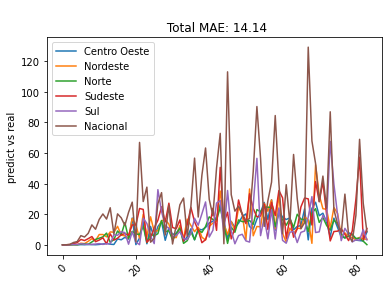

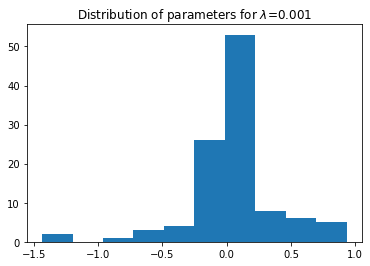

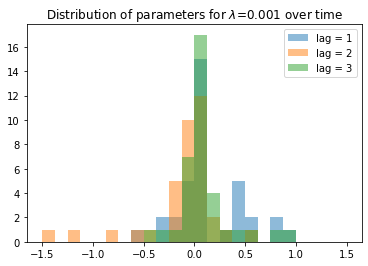

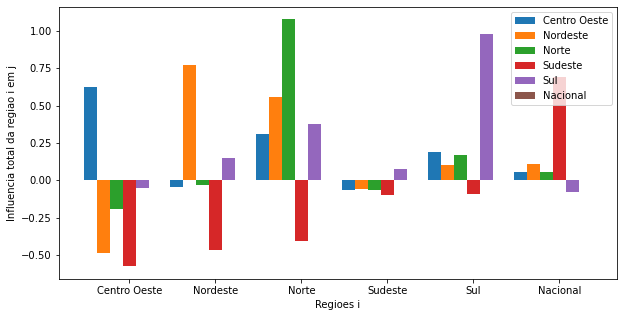

------------------------


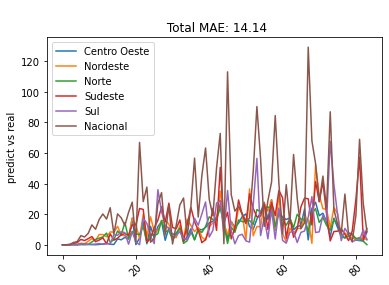

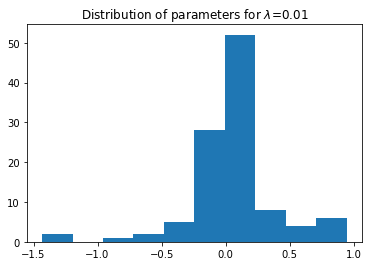

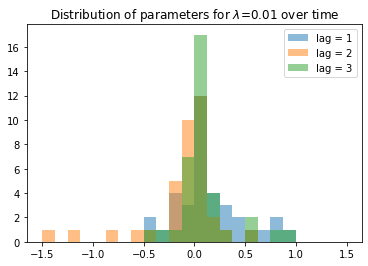

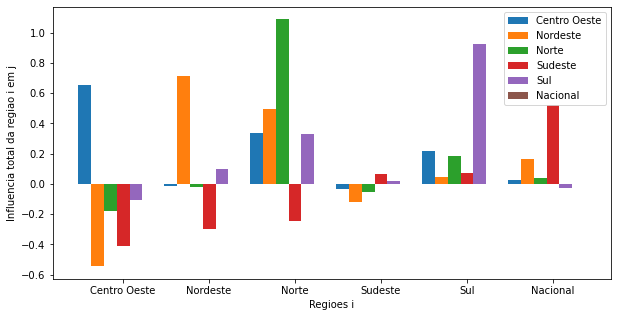

------------------------


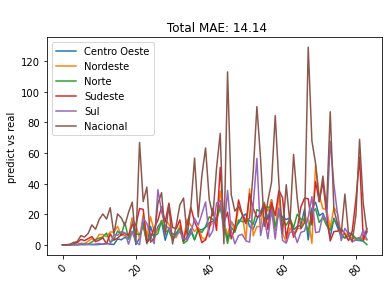

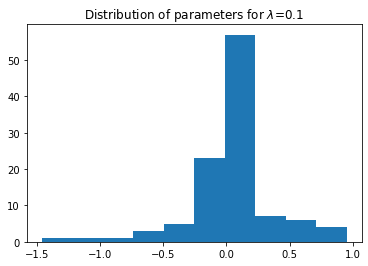

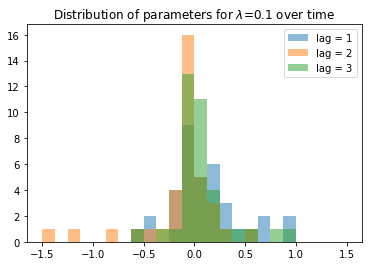

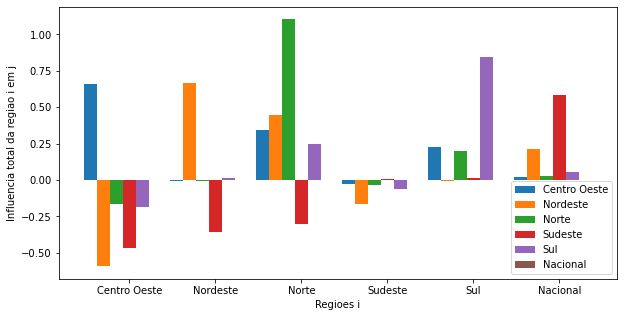

------------------------


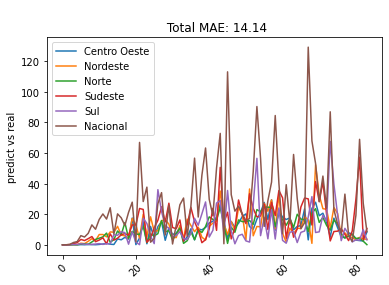

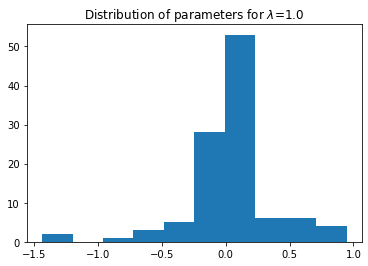

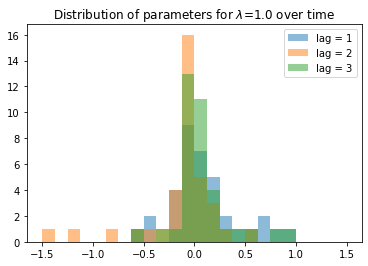

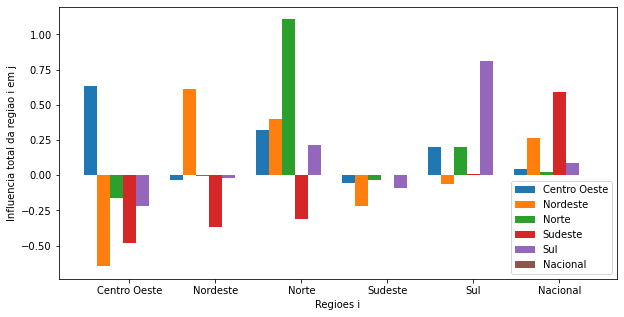

------------------------


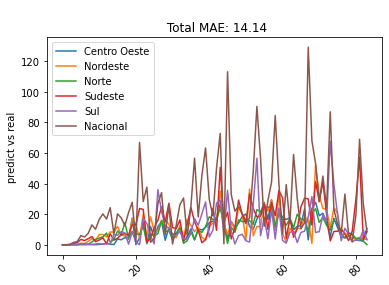

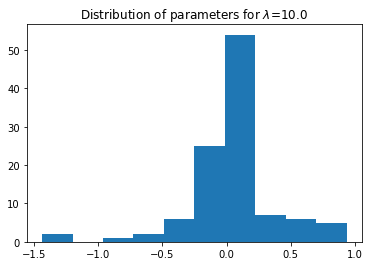

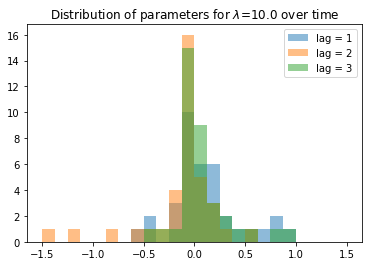

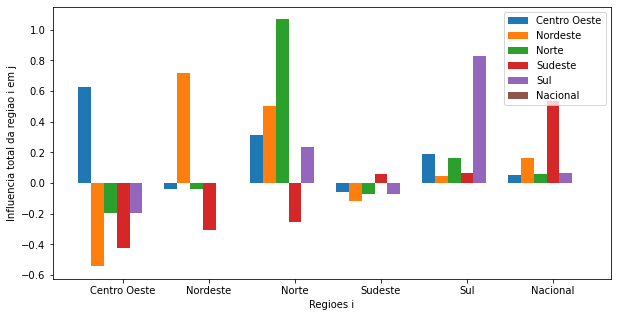

------------------------


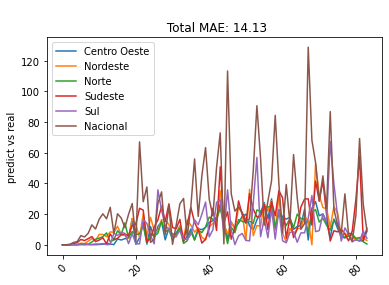

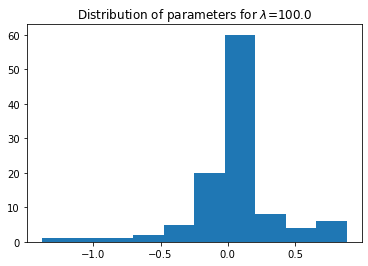

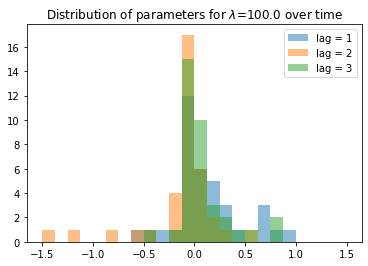

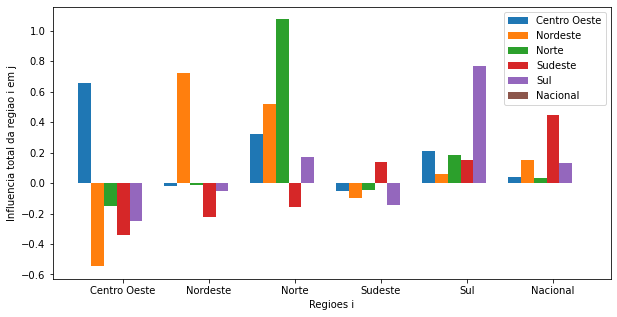

------------------------


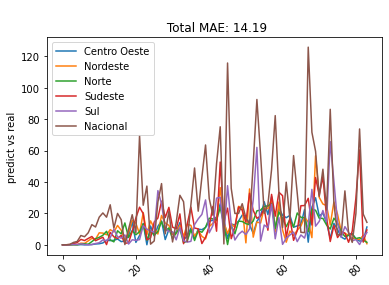

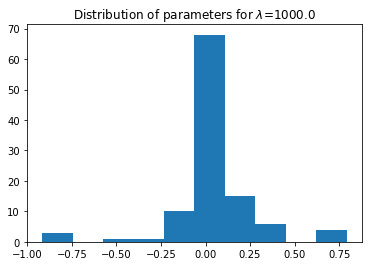

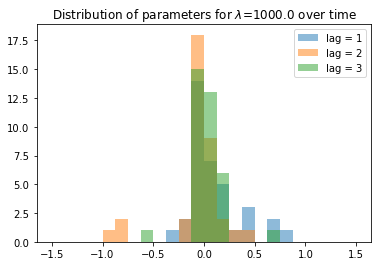

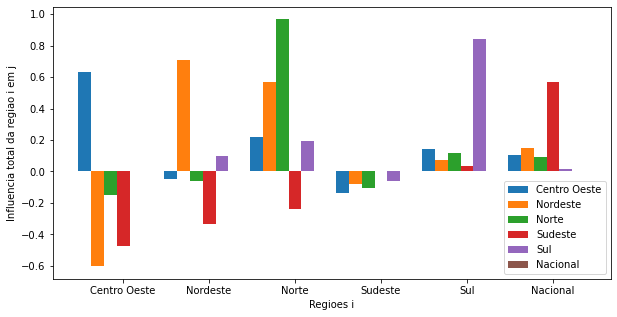

------------------------


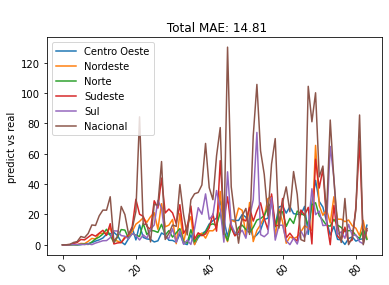

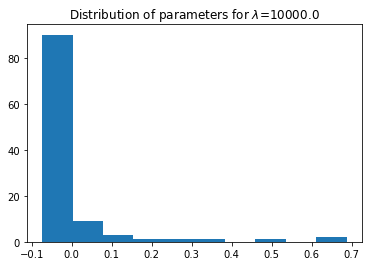

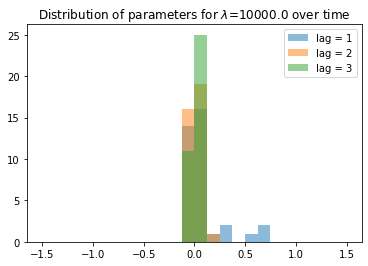

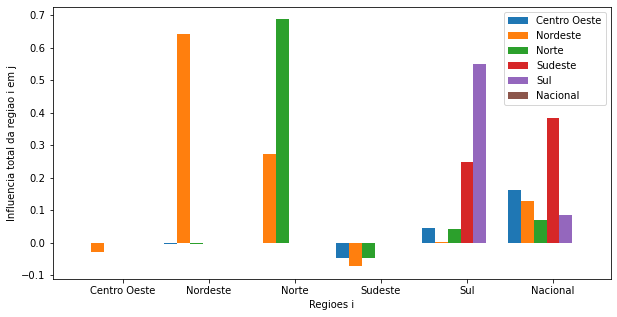

------------------------


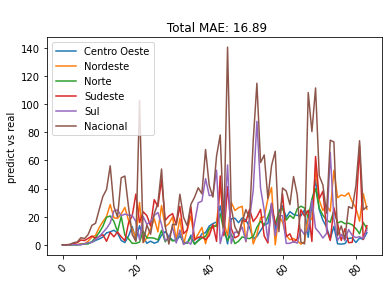

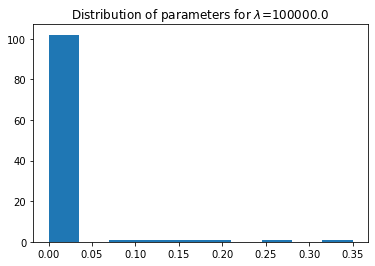

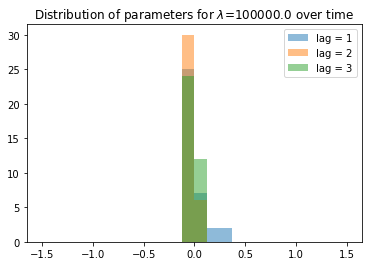

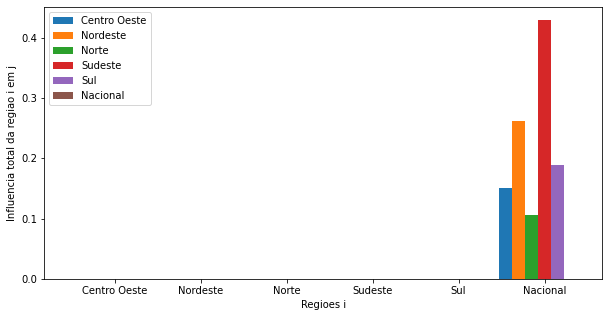

------------------------


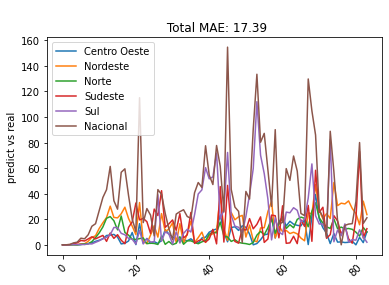

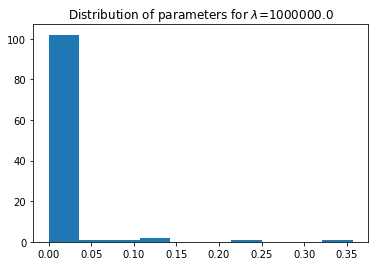

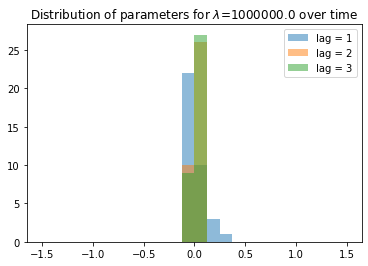

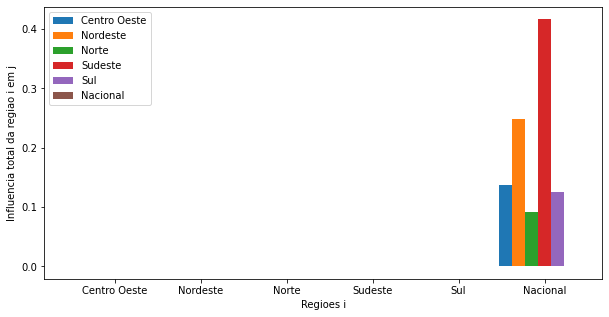

------------------------


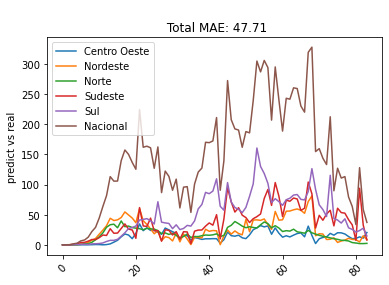

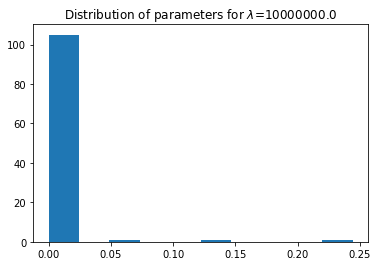

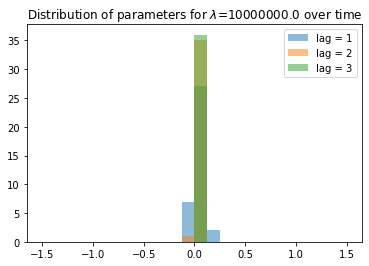

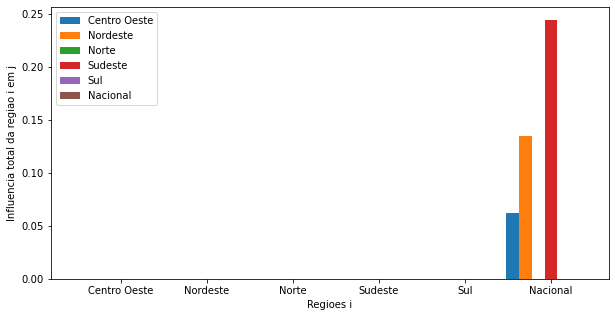

------------------------


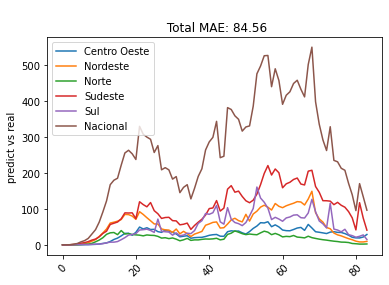

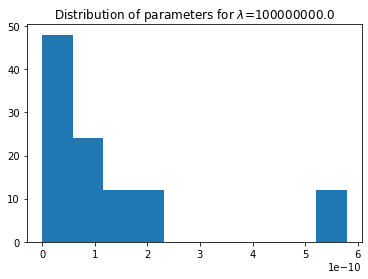

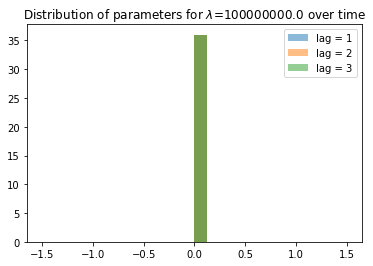

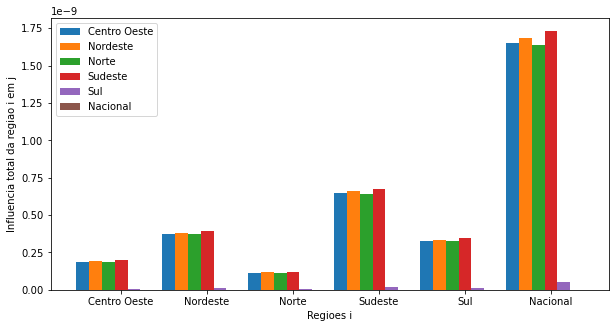

------------------------


In [77]:
Y_nacional = np.vstack([Y.copy(),np.sum(Y,axis=0)])
no_preds = []
no_preds_mse = []
for lambda_ in lambdas:
    constraints,C,Y_hat = make_constraints(Y_nacional.copy())
    constraints = constraints[:int(len(constraints)*5/6)]
    for t in range(Y_nacional.shape[1]-n):
        constraints += [Y_hat[5,t+n] == cp.sum(Y_hat[:4,t+n])]
    obj = cp.Minimize(cp.sum_squares(Y_hat - Y_nacional) + lambda_*cp.norm1(cp.hstack(C)))
    p = cp.Problem(obj,constraints)
    p.solve()
    no_preds.append(np.mean(np.abs(Y_nacional[:4,:] - Y_hat.value[:4,:])))
    no_preds_mse.append(np.mean((Y_nacional[:4,:] - Y_hat.value[:4,:])**2))
    make_plot_Y(Y_nacional,Y_hat,lambda_)
    make_plot_C(C,lambda_)
    make_plot_C_3d(C,lambda_,False)
    make_plot_C_dependencias(C)
    print("------------------------")

## Model with Graph Simple Exponential Smoothing (optimize alphas + l0)

In [32]:
def estimate_init_level(endog):
    exog = np.c_[np.ones(10), np.arange(10) + 1]
    if endog.ndim == 1:
        endog = np.atleast_2d(endog).T
    beta = np.squeeze(np.linalg.pinv(exog).dot(endog[:10]))
    return beta[0]

In [33]:
## Y is k time series with size n
shape = Y.shape

In [34]:
def make_bounds(shape):
    alpha_bounds = [(0,1)]*(2*shape[0]**2)
    return alpha_bounds
def make_constraints_2(shape):
    cons = [{'type': 'eq', 'fun': lambda x:  np.sum(x[2*i*shape[0]:2*i*shape[0] + 2*shape[0]]) - 1} for i in range(shape[0])]
    return cons

In [35]:
def normalize_alphas(alphas,shape):
    for i in range(shape[0]):
        alphas[i*2*shape[0]:(i+1)*2*shape[0]] /= np.sum(alphas[i*2*shape[0]:(i+1)*2*shape[0]])
    return alphas

In [36]:
def normalize_alphas_2(alphas,shape):
    for i in range(shape[0]):
        alphas[i*4*shape[0]:(i+1)*4*shape[0]] /= np.sum(alphas[i*4*shape[0]:(i+1)*4*shape[0]])
    return alphas

In [37]:
def normalize_alphas_3(alphas,shape):
    offset = shape[0]*4 + 1
    for i in range(shape[0]):
        alphas[i*offset:(i+1)*offset:4] /= np.sum(alphas[i*offset:(i+1)*offset:4])
    return alphas

In [38]:
shape = Y.shape
model_args = {}
model_args["_l"] = np.zeros(shape)
model_args["_y"] = Y
def sum_squared_error_2(params,model_args,other_args=None):
    Y = model_args["_y"]
    L = np.zeros((Y.shape[0],Y.shape[1]+1))
    L[:,0] = params[-shape[0]:]
    alphas = params[:-shape[0]]
    #alphas = normalize_alphas_2(alphas,shape)
    alphas = normalize_alphas_3(alphas,shape)
    for t in range(shape[1]):
        for i in range(shape[0]):
            offset = shape[0]*4 + 1
            e = alphas[(i+1)*offset - 1]
            offset *= i 
            for j in range(shape[0]):
                a = alphas[offset + j*4]
                b = alphas[offset + j*4 + 1]
                c = alphas[offset + j*4 + 2]
                d = alphas[offset + j*4 + 3]
                L[i,t] += a*Y[j,t-1] + e*(b * L[j,t-1] + c*Y[j,t-2] + d*Y[j,t-3])
    model_args["_l"] = L
    err = np.mean(np.power(Y-L[:,1:],2))
    if err == np.nan:
        err = np.inf
    return err

In [39]:
def make_bounds_2(shape):
    alpha_bounds = [(0,1)]*(4*shape[0]**2)
    l0_bounds = [(-np.inf,np.inf)]*shape[0]
    return np.vstack([alpha_bounds,l0_bounds])

In [40]:
def make_bounds_3(shape):
    offset = shape[0]*4 + 1
    alpha_bounds = [(-np.inf,np.inf)]*(4*shape[0]**2 + 5)
    for i in range(shape[0]):
        alpha_bounds[i*offset:(i+1)*offset:4] = [(0,1)]*6
    l0_bounds = [(-np.inf,np.inf)]*shape[0]
    return np.vstack([alpha_bounds,l0_bounds])

In [41]:
bounds = make_bounds_3(shape)
init_alphas = np.zeros(4*shape[0]**2 + shape[0])
constraints,C,Y_hat = make_constraints(Y.copy(),pred,True)
obj = cp.Minimize(cp.sum_squares(Y_hat - Y))
p = cp.Problem(obj,constraints)
p.solve()
init_l0 = np.zeros(shape[0])
for i in range(shape[0]):
    offset = shape[0]*4 + 1
    for j in range(shape[0]):
        for l in range(k):
            init_alphas[offset*i + j*4 + 1 + l] = C[l].value[i,j]
    init_alphas[i*offset:(i+1)*offset:4] = 1/6
    init_l0[i] = estimate_init_level(Y[i,:])
init_params = np.hstack([init_alphas,init_l0])

In [42]:
res = minimize(
                fun=sum_squared_error_2,
                x0=init_params,
                args=model_args,
                bounds=bounds,
                method="SLSQP"
              )

/tmp/ipykernel_5039/2601812346.py:24: RuntimeWarning: overflow encountered in power
  err = np.mean(np.power(Y-L[:,1:],2))


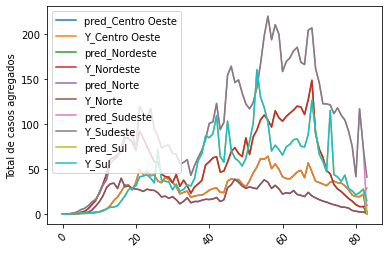

In [43]:
L = model_args["_l"]
for i in range(5):
    plt.plot(L[i,1:],label=f"pred_{labels[i]}")
    plt.plot(Y[i,:],label=f"Y_{labels[i]}")
plt.legend()
plt.ylabel("Total de casos agregados")
plt.xticks(rotation=45)
plt.show()

In [44]:
sum_squared_error_2(res.x,model_args)

6.658349595083183

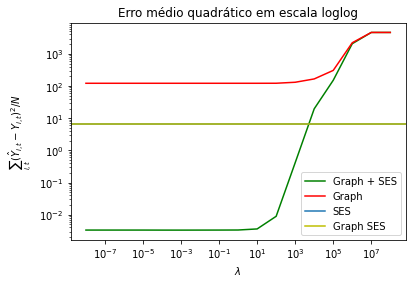

In [45]:
plt.plot(lambdas,with_preds_mse,label="Graph + SES",color="g")
plt.plot(lambdas,no_preds_mse,label="Graph",color="r")
plt.axhline(np.mean((pred-Y)**2),label="SES")
plt.axhline(np.mean((L[:,1:]-Y)**2),label="Graph SES",color="y")
plt.xlabel("$\lambda$")
plt.ylabel("$\sum_{i,t} (\hat{Y}_{i,t} - Y_{i,t})^2/N$")
plt.title("Erro médio quadrático em escala loglog")
plt.legend()
plt.loglog()
plt.show()